<a href="https://colab.research.google.com/github/hatef-hosseinpour/dental-clf/blob/main/dental_classification_ds_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/reineking/pyds.git

  Cloning https://github.com/reineking/pyds.git to /tmp/pip-req-build-13gaf_zc
  Running command git clone --filter=blob:none --quiet https://github.com/reineking/pyds.git /tmp/pip-req-build-13gaf_zc
  Resolved https://github.com/reineking/pyds.git to commit 30d669c5826366031ae820623e18f0546a3fa3d6
  Preparing metadata (setup.py) ... done
  Created wheel for py_dempster_shafer: filename=py_dempster_shafer-0.7-py3-none-any.whl size=14427 sha256=9c8dc67a0f1cf070d661baaa25c4cb367c2d371e29e8e68dc0c24cea9f9a0529
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4437mct/wheels/67/27/56/93decf8ecb1e5a253124d604ccee45e3de121fd3a67e9c00b1
Successfully built py_dempster_shafer


In [ ]:
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
from PIL import Image
import gc
import math
from tqdm import tqdm
from pyds import MassFunction, powerset
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

In [ ]:
# Set global configuration with the SAME parameters as your successful implementation
CONFIG = {
    'IMAGE_SIZE': 224,  # Important: Use the same image size as your successful model
    'BATCH_SIZE': 32,
    'LEARNING_RATE': 0.001,
    'EPOCHS': 30,
    'SEED': 42,
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'NORMALIZATION_MEAN': [0.5, 0.5, 0.5],
    'NORMALIZATION_STD': [0.5, 0.5, 0.5],
    'SAVE_PATH': "/content/drive/MyDrive/Dentisrty/models/",
    'METRICS_PATH': "/content/drive/MyDrive/Dentisrty/metrics/"
}

In [ ]:
# Define the label mapping
LABEL_MAPPING = {'amalgam_filling': 0, 'caries': 1, 'healthy': 2}

In [ ]:
# Models to test
MODELS_TO_TEST = [
    'vit_b_32',
    'vit_b_16',
    'mobilenet_v3_large',
    'densenet121',
    'efficientnet_b4',
    'vgg16',
    'resnet50',
    'resnet18',
]

In [ ]:
def seed_everything(seed_value=42):
    """Set seed for reproducibility across all libraries"""
    import random
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set the seed for reproducibility
seed_everything(CONFIG['SEED'])

In [ ]:
train_transforms = transforms.Compose([
        transforms.Resize((CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE'])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),  # Added vertical flip
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),  # Enhanced color jittering
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Added affine transformation
        transforms.ToTensor(),
        transforms.Normalize(CONFIG['NORMALIZATION_MEAN'], CONFIG['NORMALIZATION_STD']),
        transforms.RandomErasing(p=0.2)  # Added random erasing for robustness
    ])

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(CONFIG['NORMALIZATION_MEAN'], CONFIG['NORMALIZATION_STD'])
])

In [ ]:
class DentalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def build_model(model_name, num_classes):
    """Create a model with pretrained weights"""
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1')
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'efficientnet_b4':
        model = models.efficientnet_b4(weights='IMAGENET1K_V1')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(weights='IMAGENET1K_V1')
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'mobilenet_v3_large':
        model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    elif model_name == 'vit_b_16':
        model = models.vit_b_16(weights='IMAGENET1K_V1')
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif model_name == 'vit_b_32':
        model = models.vit_b_32(weights='IMAGENET1K_V1')
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported")

    return model.to(CONFIG['DEVICE'])

In [ ]:
def load_data(data_dir):
    """Load images and labels from directories"""
    images = []
    labels = []
    label_counts = {label: 0 for label in LABEL_MAPPING.keys()}

    for class_name, label_idx in LABEL_MAPPING.items():
        folder_path = os.path.join(data_dir, class_name)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                image = cv2.imread(file_path, cv2.IMREAD_COLOR)
                if image is not None:
                    # Convert BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = Image.fromarray(image)
                    images.append(image)
                    labels.append(label_idx)
                    label_counts[class_name] += 1
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    print(f"Loaded class distribution: {label_counts}")
    return images, labels

In [ ]:
def plot_distribution(labels):
    """Plot the distribution of classes"""
    plt.figure(figsize=(10, 6))
    plt.title('Distribution of Images by Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')

    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    x = list(LABEL_MAPPING.keys())
    y = [label_counts.get(LABEL_MAPPING[key], 0) for key in x]

    plt.bar(x, y)
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
def logits_to_mass_improved(logits):
    """
    Improved function to convert logits to mass functions with adaptive uncertainty.

    Args:
        logits: Raw model outputs

    Returns:
        MassFunction object
    """
    # Convert to numpy and apply softmax to get probabilities
    logits = np.array(logits)
    probs = torch.softmax(torch.tensor(logits), dim=0).numpy()

    # Get class names and prepare empty mass dictionary
    mass = {}
    class_names = list(LABEL_MAPPING.keys())
    num_classes = len(probs)
    # Calculate entropy of the probability distribution to measure uncertainty
    h = entropy(probs, base=np.e) # Normalized entropy [0,1]

    # Maximum possible entropy for this number of classes
    max_h = np.log(num_classes)  # For normaliSzed entropy using the number of classes as the base

    # Calculate adaptive uncertainty using the formula: 0.1 + 0.8 * (h / max_h)
    # This gives a minimum uncertainty of 0.1 and a maximum of 0.9
    uncertainty = 0.1 + 0.8 * (h / max_h)

    # Get all possible subsets using pyds powerset
    all_subsets = [s for s in list(powerset(class_names)) if s]  # Exclude empty set

    # Assign mass to singleton classes based on their probabilities
    # but reduced by the uncertainty
    for i, class_name in enumerate(class_names):
        subset = frozenset([class_name])
        mass[subset] = float(probs[i] * (1 - uncertainty))

    # Distribute uncertainty mass to combination sets
    multi_class_subsets = [s for s in all_subsets if len(s) > 1]

    if multi_class_subsets and uncertainty > 0:
        # Calculate distribution weights based on pairwise products of the components
        weights = []
        for subset in multi_class_subsets:
            # Use product of probabilities to calculate the weight
            subset_probs = [probs[LABEL_MAPPING[cls]] for cls in subset]
            weight = np.prod(subset_probs)
            weights.append(weight)

        # Normalize weights and distribute uncertainty
        weight_sum = sum(weights)
        if weight_sum > 0:
            for i, subset in enumerate(multi_class_subsets):
                mass[subset] = float(uncertainty * (weights[i] / weight_sum))
        else:
            # If all weights are zero, distribute uncertainty equally
            for subset in multi_class_subsets:
                mass[subset] = float(uncertainty / len(multi_class_subsets))

    # Ensure the sum is exactly 1.0 by adjusting the largest mass
    total_mass = sum(mass.values())
    if total_mass > 0 and abs(total_mass - 1.0) > 1e-10:
        largest_key = max(mass.keys(), key=lambda k: mass[k])
        mass[largest_key] = mass[largest_key] + (1.0 - total_mass)

    # Create and return the mass function
    return MassFunction(mass)


In [ ]:
def train_models(model_1, model_2, train_loader, criterion, model_1_optimizer, model_2_optimizer):
    """Train both models for one epoch"""
    model_1.train()
    model_2.train()

    total_model_1_loss = 0
    total_model_2_loss = 0
    num_batches = len(train_loader)

    for inputs, labels in tqdm(train_loader, desc='Training'):
        inputs, labels = inputs.to(CONFIG['DEVICE']), labels.to(CONFIG['DEVICE'])

        # Train model 1 (ResNet18)
        model_1_optimizer.zero_grad()
        model_1_outputs = model_1(inputs)
        model_1_loss = criterion(model_1_outputs, labels)
        model_1_loss.backward()
        model_1_optimizer.step()
        total_model_1_loss += model_1_loss.item()

        # Train model 2 (DenseNet121)
        model_2_optimizer.zero_grad()
        model_2_outputs = model_2(inputs)
        model_2_loss = criterion(model_2_outputs, labels)
        model_2_loss.backward()
        model_2_optimizer.step()
        total_model_2_loss += model_2_loss.item()

    return total_model_1_loss / num_batches, total_model_2_loss / num_batches

In [ ]:
def combine_masses(mass1, mass2):
    """Dempster's rule of combination with conflict handling"""
    try:
        # Try normal combination
        result = mass1 & mass2
        return result
    except Exception as e:
        print(f"Dempster's combination error: {e}")
        # Fall back to a mixture in case of high conflict
        combined = {}
        for k in set(mass1.keys()) | set(mass2.keys()):
            combined[k] = (mass1[k] + mass2[k]) / 2
        return MassFunction(combined)

In [ ]:
def evaluate_with_ds(model_1, model_2, dataloader, phase="val", visualize=False):
    """Evaluate using both models as evidence sources"""
    model_1.eval()
    model_2.eval()

    total_acc = 0
    total_count = 0
    all_labels = []
    all_preds = []
    all_probs = []
    all_combined_masses = []

    label_name_to_idx = LABEL_MAPPING
    label_idx_to_name = {v: k for k, v in LABEL_MAPPING.items()}

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc=f'Evaluating {phase}')):
            images, labels = images.to(CONFIG['DEVICE']), labels.to(CONFIG['DEVICE'])

            # Get predictions from both models
            model_1_outputs = model_1(images)
            model_2_outputs = model_2(images)

            model_1_probs = torch.softmax(model_1_outputs, dim=1)
            model_2_probs = torch.softmax(model_2_outputs, dim=1)

            batch_masses = []
            batch_beliefs = []

            for i in range(len(images)):
                # Convert logits to mass functions with improved method
                model_1_mass = logits_to_mass_improved(model_1_outputs[i].cpu().numpy())
                model_2_mass = logits_to_mass_improved(model_2_outputs[i].cpu().numpy())

                # Combine evidence using Dempster's rule
                combined_mass = combine_masses(model_1_mass, model_2_mass)
                batch_masses.append(combined_mass)

                # Calculate beliefs for each class
                beliefs = {}
                for label in LABEL_MAPPING.keys():
                    beliefs[label] = combined_mass.bel({label})
                batch_beliefs.append(beliefs)

                # Make prediction based on maximum belief
                pred_class = max(beliefs.items(), key=lambda x: x[1])[0]
                pred_idx = label_name_to_idx[pred_class]

                # Update metrics
                total_acc += (pred_idx == labels[i].item())
                total_count += 1

                # Store results
                all_labels.append(labels[i].cpu().item())
                all_preds.append(pred_idx)

                # Average probabilities from both models as a crude fusion approach
                combined_probs = (model_1_probs[i] + model_2_probs[i]) / 2
                all_probs.append(combined_probs.cpu().numpy())
                all_combined_masses.append(combined_mass)

            # Visualize results for first batch in test phase
            if visualize and phase == "test" and batch_idx == 0:
                visualize_results(images, batch_beliefs, labels, batch_idx)

    # Calculate metrics
    accuracy = total_acc / total_count
    all_labels_np = np.array(all_labels)
    all_preds_np = np.array(all_preds)

    # Compute metrics
    metrics = {
        'accuracy': accuracy,
        'precision': precision_score(all_labels_np, all_preds_np, average='weighted'),
        'recall': recall_score(all_labels_np, all_preds_np, average='weighted'),
        'f1_score': f1_score(all_labels_np, all_preds_np, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels_np, all_preds_np)
    }

    if phase == "test":
        print_detailed_metrics(metrics)

    return accuracy, metrics, all_combined_masses

In [ ]:
def train_and_evaluate_model_pair(model1_name, model2_name, train_loader, val_loader, test_loader):
    """Train and evaluate a specific pair of models"""
    print(f"\n{'='*60}")
    print(f"Training pair: {model1_name} + {model2_name}")
    print(f"{'='*60}")

    # Initialize models
    model_1 = build_model(model1_name, num_classes=len(LABEL_MAPPING))
    model_2 = build_model(model2_name, num_classes=len(LABEL_MAPPING))

    criterion = nn.CrossEntropyLoss()
    model_1_optimizer = optim.AdamW(model_1.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-4)
    model_2_optimizer = optim.AdamW(model_2.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-4)

    # Create schedulers
    model_1_scheduler = optim.lr_scheduler.CosineAnnealingLR(model_1_optimizer, T_max=CONFIG['EPOCHS'])
    model_2_scheduler = optim.lr_scheduler.CosineAnnealingLR(model_2_optimizer, T_max=CONFIG['EPOCHS'])

    # Training loop
    best_val_accuracy = 0.0

    for epoch in range(CONFIG['EPOCHS']):
        # Train
        model_1_loss, model_2_loss = train_models(
            model_1, model_2, train_loader,
            criterion, model_1_optimizer, model_2_optimizer
        )

        # Step schedulers
        model_1_scheduler.step()
        model_2_scheduler.step()

        # Validate every 5 epochs to save time
        # if (epoch + 1) % 5 == 0 or epoch == CONFIG['EPOCHS'] - 1:
        val_accuracy, val_metrics, _ = evaluate_with_ds(
            model_1, model_2, val_loader, "val"
        )

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # Save best models with pair names
            torch.save(model_1.state_dict(),
                      os.path.join(CONFIG['SAVE_PATH'], f'best_{model1_name}_{model2_name}_model1.pth'))
            torch.save(model_2.state_dict(),
                      os.path.join(CONFIG['SAVE_PATH'], f'best_{model1_name}_{model2_name}_model2.pth'))

        print(f'Epoch {epoch+1}: Val Accuracy: {val_accuracy:.4f}, Best: {best_val_accuracy:.4f}')

    # Final test evaluation
    test_accuracy, test_metrics, _ = evaluate_with_ds(
        model_1, model_2, test_loader, "test"
    )

    print(f'Final Test Accuracy for {model1_name}+{model2_name}: {test_accuracy:.4f}')

    # Clear GPU memory
    del model_1, model_2, model_1_optimizer, model_2_optimizer
    torch.cuda.empty_cache()
    gc.collect()

    return {
        'model1_name': model1_name,
        'model2_name': model2_name,
        'test_accuracy': test_accuracy,
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_f1_score': test_metrics['f1_score']
    }

In [ ]:
def print_detailed_metrics(metrics):
    """Print detailed metrics for test evaluation"""
    print("\n----- Detailed Metrics -----")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")

    # Display confusion matrix
    cm = metrics['confusion_matrix']

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=list(LABEL_MAPPING.keys()),
                yticklabels=list(LABEL_MAPPING.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def visualize_results(images, batch_beliefs, labels, batch_idx=0):
    """Visualize prediction results"""
    num_images = min(16, len(images))
    grid_cols = 4
    grid_rows = math.ceil(num_images / grid_cols)

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 4 * grid_rows))
    if grid_rows == 1 and grid_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    # Get mapping from index to label name
    label_idx_to_name = {v: k for k, v in LABEL_MAPPING.items()}

    for i, ax in enumerate(axes):
        if i < num_images:
            # Get image
            img = images[i].cpu().numpy().transpose(1, 2, 0)
            img = img * np.array(CONFIG['NORMALIZATION_STD']) + np.array(CONFIG['NORMALIZATION_MEAN'])
            img = np.clip(img, 0, 1)

            # Get beliefs and make prediction
            beliefs = batch_beliefs[i]
            pred_class = max(beliefs.items(), key=lambda x: x[1])[0]
            true_class = label_idx_to_name[labels[i].item()]

            # Format belief text
            belief_text = "\n".join(f"{label}: {belief:.4f}" for label, belief in beliefs.items())

            # Show image with predictions
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}\n\nBeliefs:\n{belief_text}", fontsize=10)

            # Highlight incorrect predictions
            if pred_class != true_class:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(3)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'ds_prediction_batch_{batch_idx}.png')
    plt.show()

Loading data...
Loaded class distribution: {'amalgam_filling': 142, 'caries': 114, 'healthy': 146}
Loaded 402 images


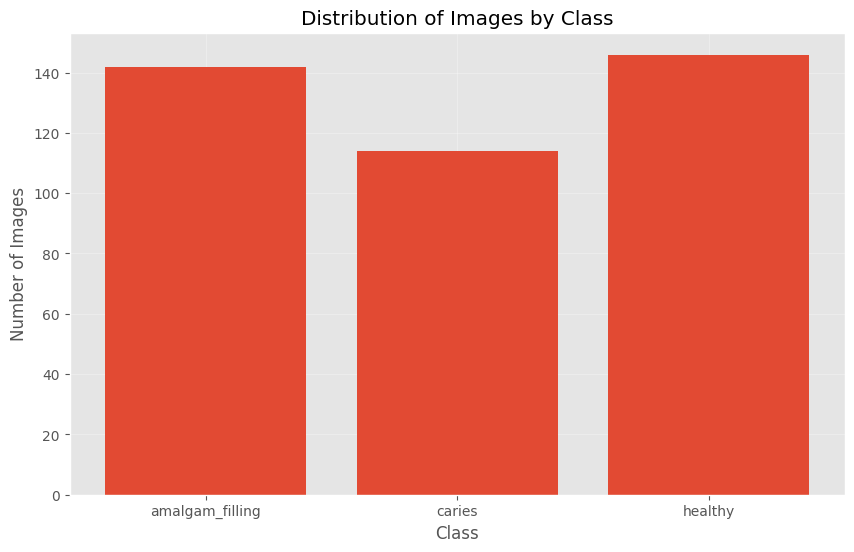

Splitting data...
Train: 256, Validation: 65, Test: 81
Creating datasets and dataloaders...

Total model pairs to test: 28
 1. vit_b_32 + vit_b_16
 2. vit_b_32 + mobilenet_v3_large
 3. vit_b_32 + densenet121
 4. vit_b_32 + efficientnet_b4
 5. vit_b_32 + vgg16
 6. vit_b_32 + resnet50
 7. vit_b_32 + resnet18
 8. vit_b_16 + mobilenet_v3_large
 9. vit_b_16 + densenet121
10. vit_b_16 + efficientnet_b4
11. vit_b_16 + vgg16
12. vit_b_16 + resnet50
13. vit_b_16 + resnet18
14. mobilenet_v3_large + densenet121
15. mobilenet_v3_large + efficientnet_b4
16. mobilenet_v3_large + vgg16
17. mobilenet_v3_large + resnet50
18. mobilenet_v3_large + resnet18
19. densenet121 + efficientnet_b4
20. densenet121 + vgg16
21. densenet121 + resnet50
22. densenet121 + resnet18
23. efficientnet_b4 + vgg16
24. efficientnet_b4 + resnet50
25. efficientnet_b4 + resnet18
26. vgg16 + resnet50
27. vgg16 + resnet18
28. resnet50 + resnet18


Testing pair 1/28

Training pair: vit_b_32 + vit_b_16


Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:04<00:00, 81.5MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 50.9MB/s]
Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch 1: Val Accuracy: 0.2462, Best: 0.2462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Epoch 2: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch 3: Val Accuracy: 0.3692, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 4: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Epoch 5: Val Accuracy: 0.3692, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epoch 6: Val Accuracy: 0.6462, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Epoch 7: Val Accuracy: 0.6615, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Epoch 8: Val Accuracy: 0.6615, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch 9: Val Accuracy: 0.6615, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Epoch 10: Val Accuracy: 0.6462, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch 11: Val Accuracy: 0.6000, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch 12: Val Accuracy: 0.6000, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch 13: Val Accuracy: 0.6000, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 14: Val Accuracy: 0.5385, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch 15: Val Accuracy: 0.6462, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch 16: Val Accuracy: 0.5538, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch 17: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Epoch 18: Val Accuracy: 0.5538, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


Epoch 19: Val Accuracy: 0.5846, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch 20: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Epoch 21: Val Accuracy: 0.5846, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch 22: Val Accuracy: 0.5692, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Epoch 23: Val Accuracy: 0.5538, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epoch 24: Val Accuracy: 0.6154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch 25: Val Accuracy: 0.5538, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch 26: Val Accuracy: 0.6154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch 27: Val Accuracy: 0.6154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Epoch 28: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch 29: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch 30: Val Accuracy: 0.6000, Best: 0.6923


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]



----- Detailed Metrics -----
Accuracy: 0.8148
Precision: 0.8404
Recall: 0.8148
F1 Score: 0.7835


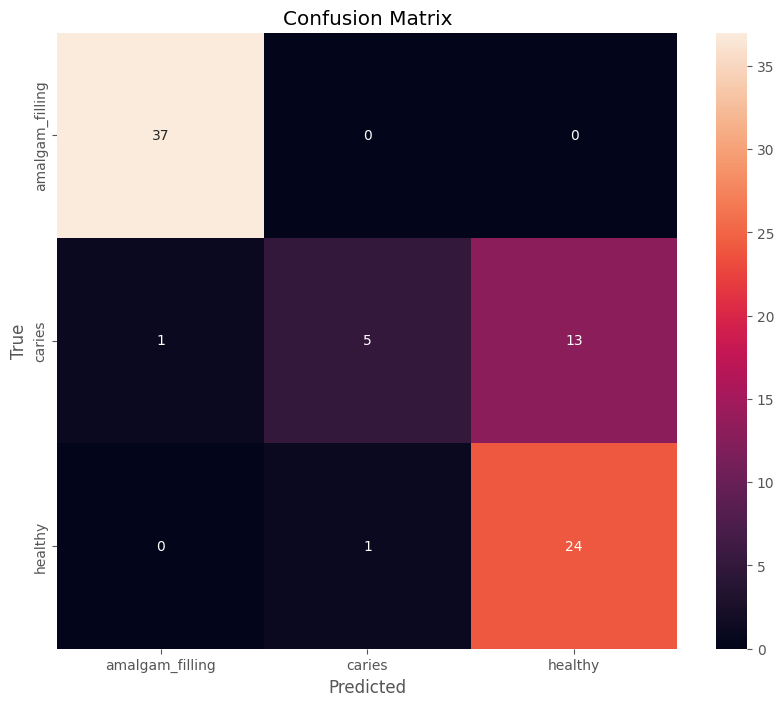

Final Test Accuracy for vit_b_32+vit_b_16: 0.8148


Testing pair 2/28

Training pair: vit_b_32 + mobilenet_v3_large


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 109MB/s]
Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]


Epoch 1: Val Accuracy: 0.4923, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s]


Epoch 2: Val Accuracy: 0.4462, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch 3: Val Accuracy: 0.4462, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch 4: Val Accuracy: 0.3385, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


Epoch 5: Val Accuracy: 0.4462, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch 6: Val Accuracy: 0.5692, Best: 0.5692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]


Epoch 7: Val Accuracy: 0.5385, Best: 0.5692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]


Epoch 8: Val Accuracy: 0.6000, Best: 0.6000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


Epoch 9: Val Accuracy: 0.3846, Best: 0.6000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]


Epoch 10: Val Accuracy: 0.4462, Best: 0.6000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.92it/s]


Epoch 11: Val Accuracy: 0.6000, Best: 0.6000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Epoch 12: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


Epoch 13: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


Epoch 14: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Epoch 15: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Epoch 16: Val Accuracy: 0.7385, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.11it/s]


Epoch 17: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 18: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Epoch 19: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


Epoch 20: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


Epoch 21: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


Epoch 22: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Epoch 23: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


Epoch 24: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]


Epoch 25: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Epoch 26: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]


Epoch 27: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]


Epoch 28: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Epoch 29: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]


Epoch 30: Val Accuracy: 0.7846, Best: 0.8308


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]



----- Detailed Metrics -----
Accuracy: 0.8765
Precision: 0.9118
Recall: 0.8765
F1 Score: 0.8648


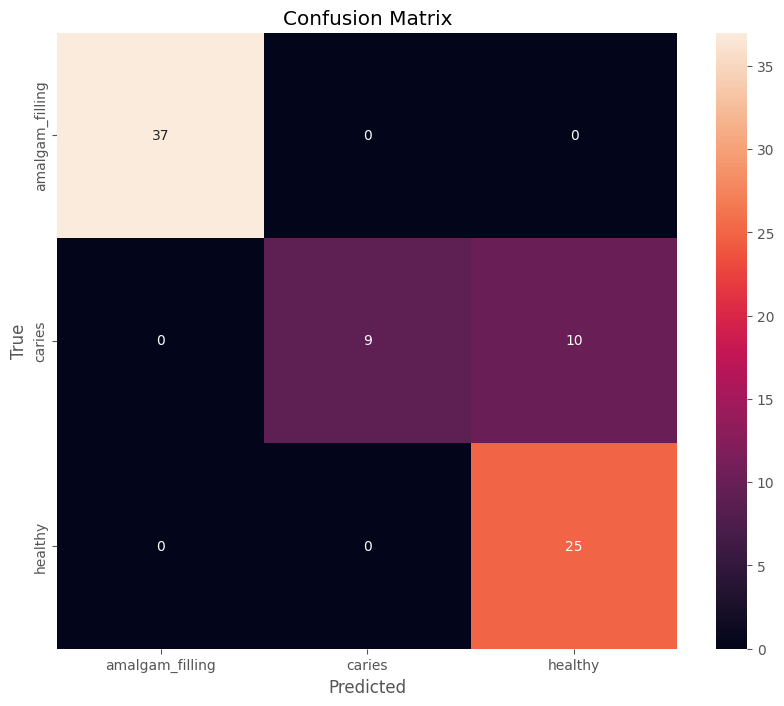

Final Test Accuracy for vit_b_32+mobilenet_v3_large: 0.8765


Testing pair 3/28

Training pair: vit_b_32 + densenet121


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 128MB/s]
Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Epoch 2: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Epoch 3: Val Accuracy: 0.3231, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epoch 4: Val Accuracy: 0.4154, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epoch 5: Val Accuracy: 0.5538, Best: 0.5538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch 6: Val Accuracy: 0.6000, Best: 0.6000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Epoch 7: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Epoch 8: Val Accuracy: 0.6308, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epoch 9: Val Accuracy: 0.7538, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Epoch 10: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Epoch 11: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Epoch 12: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Epoch 13: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 14: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epoch 15: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Epoch 16: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Epoch 17: Val Accuracy: 0.7231, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch 18: Val Accuracy: 0.7538, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Epoch 19: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Epoch 20: Val Accuracy: 0.7846, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


Epoch 21: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


Epoch 22: Val Accuracy: 0.7846, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch 23: Val Accuracy: 0.7538, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 24: Val Accuracy: 0.7385, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Epoch 25: Val Accuracy: 0.7692, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


Epoch 26: Val Accuracy: 0.7538, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Epoch 27: Val Accuracy: 0.7692, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Epoch 28: Val Accuracy: 0.7692, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 29: Val Accuracy: 0.7846, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch 30: Val Accuracy: 0.7846, Best: 0.8462


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9321
Recall: 0.9259
F1 Score: 0.9259


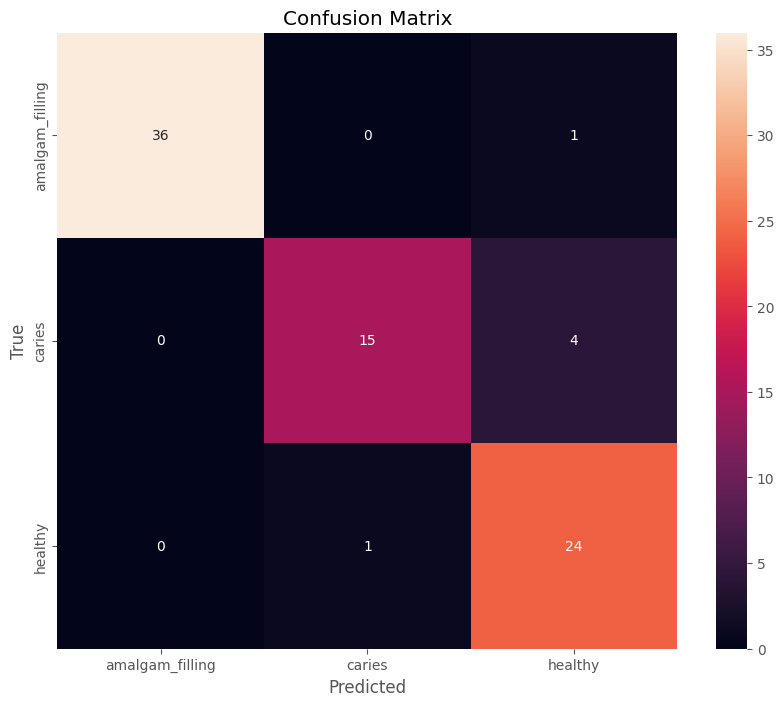

Final Test Accuracy for vit_b_32+densenet121: 0.9259


Testing pair 4/28

Training pair: vit_b_32 + efficientnet_b4


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 102MB/s]
Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Epoch 1: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch 2: Val Accuracy: 0.6308, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch 3: Val Accuracy: 0.5846, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


Epoch 4: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch 5: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 6: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Epoch 7: Val Accuracy: 0.7692, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Epoch 8: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 9: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Epoch 10: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch 11: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Epoch 12: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


Epoch 13: Val Accuracy: 0.8615, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epoch 14: Val Accuracy: 0.8769, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epoch 15: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch 16: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


Epoch 17: Val Accuracy: 0.7538, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epoch 18: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Epoch 19: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


Epoch 20: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Epoch 21: Val Accuracy: 0.7692, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 22: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Epoch 23: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


Epoch 24: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Epoch 25: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


Epoch 26: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Epoch 27: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Epoch 28: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Epoch 29: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


Epoch 30: Val Accuracy: 0.8000, Best: 0.8769


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]



----- Detailed Metrics -----
Accuracy: 0.9383
Precision: 0.9412
Recall: 0.9383
F1 Score: 0.9374


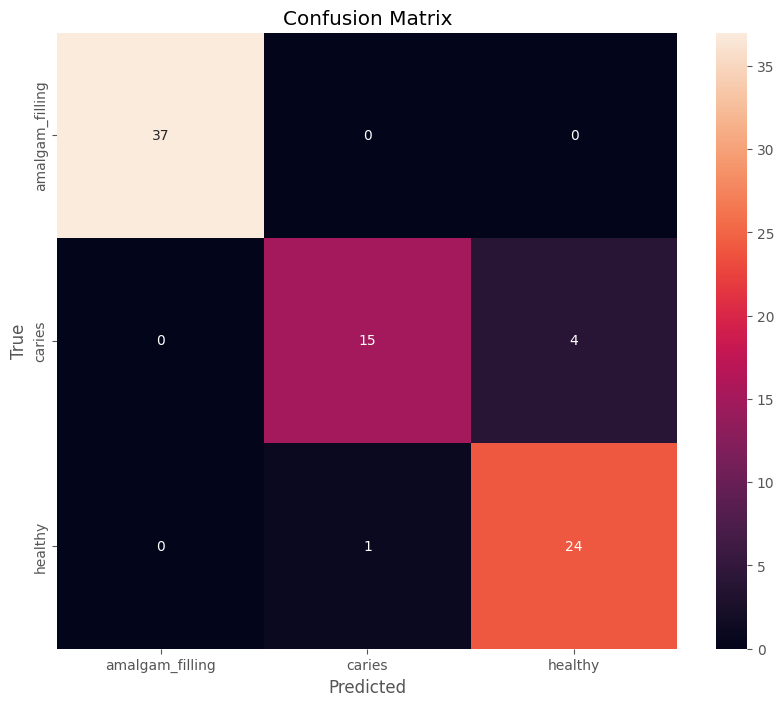

Final Test Accuracy for vit_b_32+efficientnet_b4: 0.9383


Testing pair 5/28

Training pair: vit_b_32 + vgg16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.6MB/s]
Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 1: Val Accuracy: 0.2308, Best: 0.2308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch 2: Val Accuracy: 0.3385, Best: 0.3385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epoch 3: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 4: Val Accuracy: 0.3385, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 5: Val Accuracy: 0.4000, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 6: Val Accuracy: 0.4462, Best: 0.4462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 7: Val Accuracy: 0.4308, Best: 0.4462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 8: Val Accuracy: 0.3385, Best: 0.4462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epoch 9: Val Accuracy: 0.4308, Best: 0.4462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch 10: Val Accuracy: 0.3385, Best: 0.4462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch 11: Val Accuracy: 0.5231, Best: 0.5231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 12: Val Accuracy: 0.6154, Best: 0.6154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch 13: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 14: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch 15: Val Accuracy: 0.6308, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 16: Val Accuracy: 0.6308, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epoch 17: Val Accuracy: 0.5077, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epoch 18: Val Accuracy: 0.6615, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Epoch 19: Val Accuracy: 0.4923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch 20: Val Accuracy: 0.6462, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch 21: Val Accuracy: 0.5385, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 22: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 23: Val Accuracy: 0.6769, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 24: Val Accuracy: 0.5846, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 25: Val Accuracy: 0.6154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch 26: Val Accuracy: 0.6154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 27: Val Accuracy: 0.6154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch 28: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Epoch 29: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 30: Val Accuracy: 0.6000, Best: 0.6923


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]



----- Detailed Metrics -----
Accuracy: 0.6420
Precision: 0.5861
Recall: 0.6420
F1 Score: 0.5773


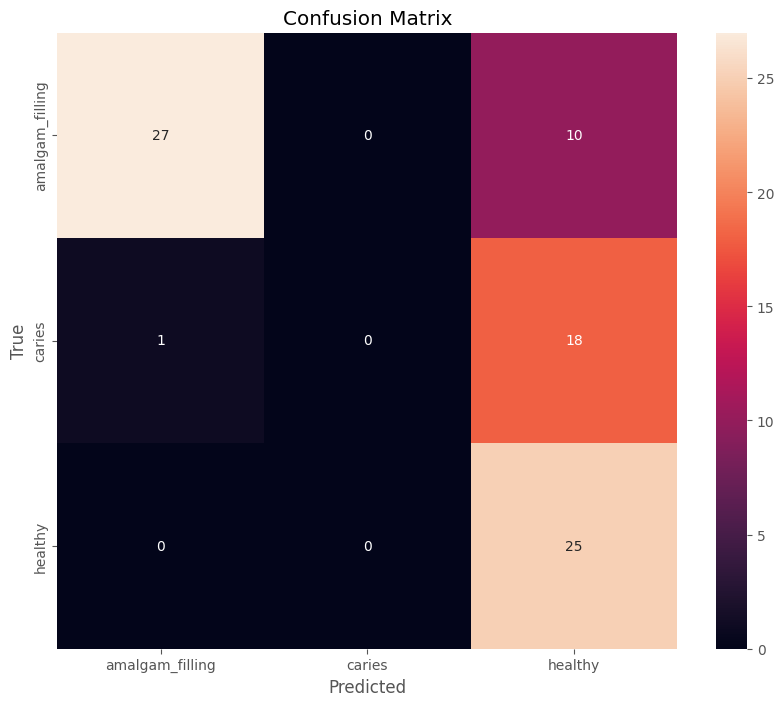

Final Test Accuracy for vit_b_32+vgg16: 0.6420


Testing pair 6/28

Training pair: vit_b_32 + resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]
Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch 2: Val Accuracy: 0.4000, Best: 0.4000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Epoch 3: Val Accuracy: 0.3692, Best: 0.4000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epoch 4: Val Accuracy: 0.4462, Best: 0.4462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 5: Val Accuracy: 0.5231, Best: 0.5231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Epoch 6: Val Accuracy: 0.4769, Best: 0.5231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 7: Val Accuracy: 0.4615, Best: 0.5231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 8: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Epoch 9: Val Accuracy: 0.7231, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


Epoch 10: Val Accuracy: 0.5846, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


Epoch 11: Val Accuracy: 0.6769, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 12: Val Accuracy: 0.6769, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 13: Val Accuracy: 0.3538, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epoch 14: Val Accuracy: 0.6923, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


Epoch 15: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Epoch 16: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 17: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


Epoch 18: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 19: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch 20: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epoch 21: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Epoch 22: Val Accuracy: 0.6462, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epoch 23: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Epoch 24: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 25: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


Epoch 26: Val Accuracy: 0.7231, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 27: Val Accuracy: 0.7231, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Epoch 28: Val Accuracy: 0.7385, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 29: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Epoch 30: Val Accuracy: 0.7846, Best: 0.8308


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]



----- Detailed Metrics -----
Accuracy: 0.8395
Precision: 0.8621
Recall: 0.8395
F1 Score: 0.8254


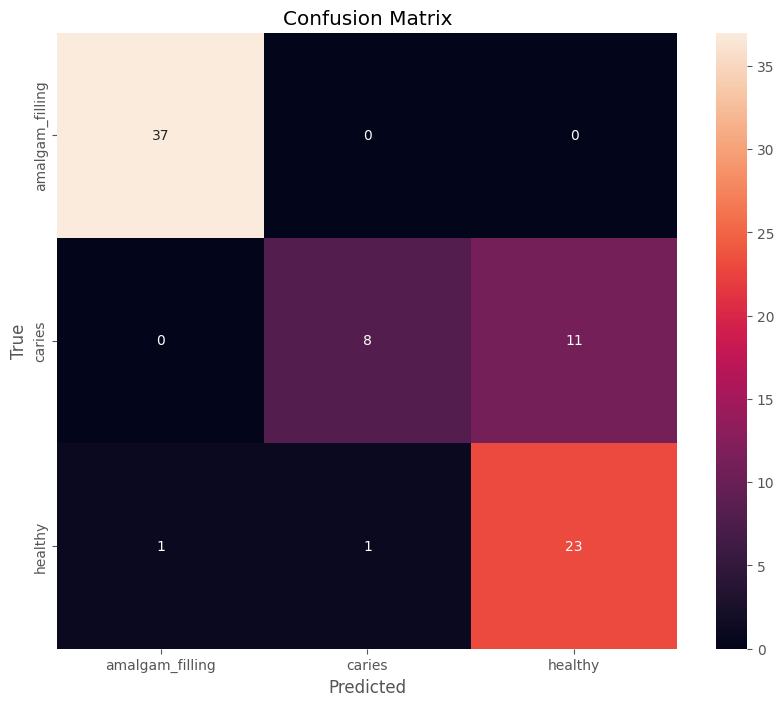

Final Test Accuracy for vit_b_32+resnet50: 0.8395


Testing pair 7/28

Training pair: vit_b_32 + resnet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Epoch 1: Val Accuracy: 0.3846, Best: 0.3846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Epoch 2: Val Accuracy: 0.3385, Best: 0.3846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Epoch 3: Val Accuracy: 0.5077, Best: 0.5077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


Epoch 4: Val Accuracy: 0.5846, Best: 0.5846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Epoch 5: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch 6: Val Accuracy: 0.7077, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch 7: Val Accuracy: 0.6923, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


Epoch 8: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Epoch 9: Val Accuracy: 0.5846, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 10: Val Accuracy: 0.7538, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


Epoch 11: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


Epoch 12: Val Accuracy: 0.7077, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 13: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


Epoch 14: Val Accuracy: 0.7538, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Epoch 15: Val Accuracy: 0.7385, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]


Epoch 16: Val Accuracy: 0.7385, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Epoch 17: Val Accuracy: 0.7231, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


Epoch 18: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


Epoch 19: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


Epoch 20: Val Accuracy: 0.7077, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]


Epoch 21: Val Accuracy: 0.6154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


Epoch 22: Val Accuracy: 0.6769, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Epoch 23: Val Accuracy: 0.6615, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]


Epoch 24: Val Accuracy: 0.6769, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Epoch 25: Val Accuracy: 0.7077, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]


Epoch 26: Val Accuracy: 0.6923, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


Epoch 27: Val Accuracy: 0.6923, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


Epoch 28: Val Accuracy: 0.6923, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


Epoch 29: Val Accuracy: 0.6923, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Epoch 30: Val Accuracy: 0.6923, Best: 0.8154


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]



----- Detailed Metrics -----
Accuracy: 0.8519
Precision: 0.8563
Recall: 0.8519
F1 Score: 0.8459


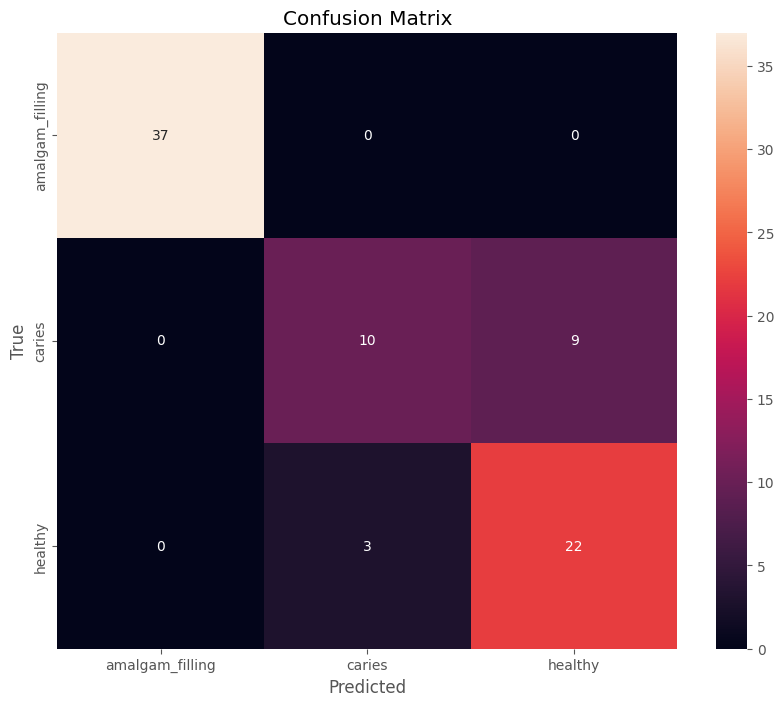

Final Test Accuracy for vit_b_32+resnet18: 0.8519


Testing pair 8/28

Training pair: vit_b_16 + mobilenet_v3_large


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch 1: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch 2: Val Accuracy: 0.3846, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Epoch 3: Val Accuracy: 0.6462, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch 4: Val Accuracy: 0.3385, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch 5: Val Accuracy: 0.5538, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch 6: Val Accuracy: 0.4154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch 7: Val Accuracy: 0.4462, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch 8: Val Accuracy: 0.4923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 9: Val Accuracy: 0.5538, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch 10: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Epoch 11: Val Accuracy: 0.7077, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch 12: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Epoch 13: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch 14: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epoch 15: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch 16: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


Epoch 17: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch 18: Val Accuracy: 0.8615, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch 19: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch 20: Val Accuracy: 0.8154, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch 21: Val Accuracy: 0.8154, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch 22: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Epoch 23: Val Accuracy: 0.7538, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch 24: Val Accuracy: 0.7385, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch 25: Val Accuracy: 0.7385, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch 26: Val Accuracy: 0.7231, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch 27: Val Accuracy: 0.7231, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Epoch 28: Val Accuracy: 0.7231, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch 29: Val Accuracy: 0.7231, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch 30: Val Accuracy: 0.7231, Best: 0.8615


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]



----- Detailed Metrics -----
Accuracy: 0.8025
Precision: 0.8306
Recall: 0.8025
F1 Score: 0.7829


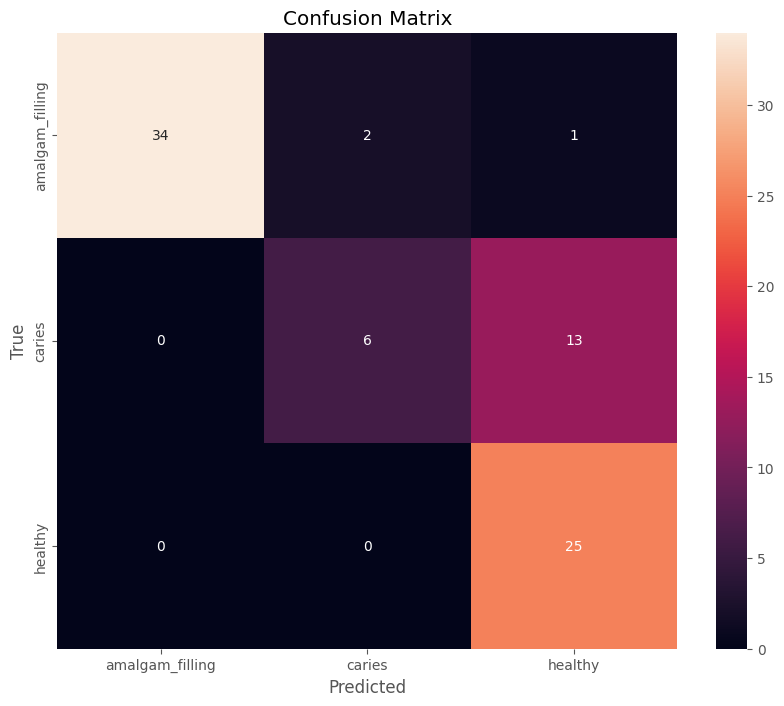

Final Test Accuracy for vit_b_16+mobilenet_v3_large: 0.8025


Testing pair 9/28

Training pair: vit_b_16 + densenet121


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch 1: Val Accuracy: 0.4615, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 2: Val Accuracy: 0.4615, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Epoch 3: Val Accuracy: 0.5385, Best: 0.5385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Epoch 4: Val Accuracy: 0.4308, Best: 0.5385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch 5: Val Accuracy: 0.6769, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


Epoch 6: Val Accuracy: 0.4769, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch 7: Val Accuracy: 0.5077, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch 8: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch 9: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


Epoch 10: Val Accuracy: 0.7385, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Epoch 11: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 12: Val Accuracy: 0.5692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch 13: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epoch 14: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Epoch 15: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Epoch 16: Val Accuracy: 0.7538, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


Epoch 17: Val Accuracy: 0.7538, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


Epoch 18: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch 19: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch 20: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Epoch 21: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch 22: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Epoch 23: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch 24: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch 25: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


Epoch 26: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch 27: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 28: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 29: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch 30: Val Accuracy: 0.7692, Best: 0.8154


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9403
Recall: 0.9259
F1 Score: 0.9229


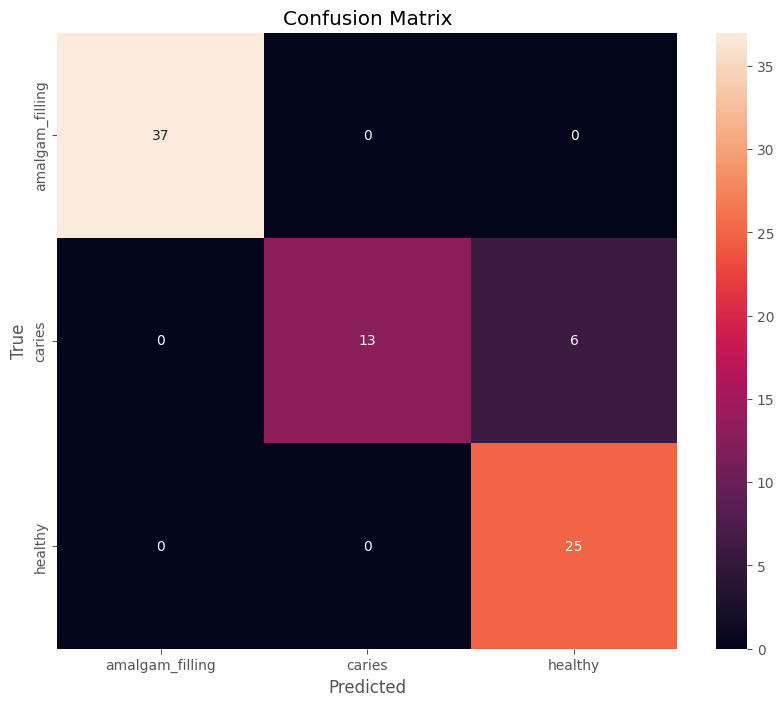

Final Test Accuracy for vit_b_16+densenet121: 0.9259


Testing pair 10/28

Training pair: vit_b_16 + efficientnet_b4


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 1: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch 2: Val Accuracy: 0.6769, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 3: Val Accuracy: 0.7538, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 4: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch 5: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Epoch 6: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch 7: Val Accuracy: 0.7385, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 8: Val Accuracy: 0.7846, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch 9: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 10: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Epoch 11: Val Accuracy: 0.7538, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 12: Val Accuracy: 0.7846, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch 13: Val Accuracy: 0.7846, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 14: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


Epoch 15: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Epoch 16: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 17: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 18: Val Accuracy: 0.7538, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch 19: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 20: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 21: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch 22: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 23: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Epoch 24: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch 25: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Epoch 26: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epoch 27: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 28: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch 29: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch 30: Val Accuracy: 0.7692, Best: 0.8308


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9403
Recall: 0.9259
F1 Score: 0.9229


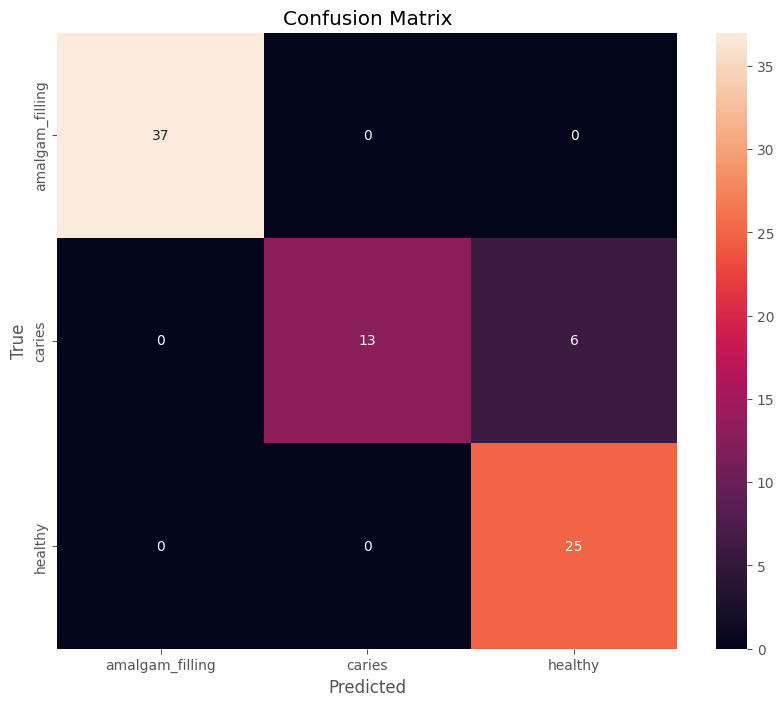

Final Test Accuracy for vit_b_16+efficientnet_b4: 0.9259


Testing pair 11/28

Training pair: vit_b_16 + vgg16


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


Epoch 1: Val Accuracy: 0.2615, Best: 0.2615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Epoch 2: Val Accuracy: 0.3538, Best: 0.3538


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epoch 3: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


Epoch 4: Val Accuracy: 0.3538, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Epoch 5: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch 6: Val Accuracy: 0.4923, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Epoch 7: Val Accuracy: 0.3077, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


Epoch 8: Val Accuracy: 0.4000, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch 9: Val Accuracy: 0.5077, Best: 0.5077


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Epoch 10: Val Accuracy: 0.4308, Best: 0.5077


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Epoch 11: Val Accuracy: 0.5231, Best: 0.5231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


Epoch 12: Val Accuracy: 0.5538, Best: 0.5538


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Epoch 13: Val Accuracy: 0.6308, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Epoch 14: Val Accuracy: 0.6000, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Epoch 15: Val Accuracy: 0.5385, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Epoch 16: Val Accuracy: 0.6000, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Epoch 17: Val Accuracy: 0.6615, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Epoch 18: Val Accuracy: 0.5538, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch 19: Val Accuracy: 0.5692, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Epoch 20: Val Accuracy: 0.5846, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch 21: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch 22: Val Accuracy: 0.5231, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch 23: Val Accuracy: 0.6154, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Epoch 24: Val Accuracy: 0.6000, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch 25: Val Accuracy: 0.6769, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Epoch 26: Val Accuracy: 0.6308, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch 27: Val Accuracy: 0.6308, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch 28: Val Accuracy: 0.6462, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch 29: Val Accuracy: 0.6308, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch 30: Val Accuracy: 0.6308, Best: 0.6923


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]



----- Detailed Metrics -----
Accuracy: 0.7654
Precision: 0.8195
Recall: 0.7654
F1 Score: 0.7429


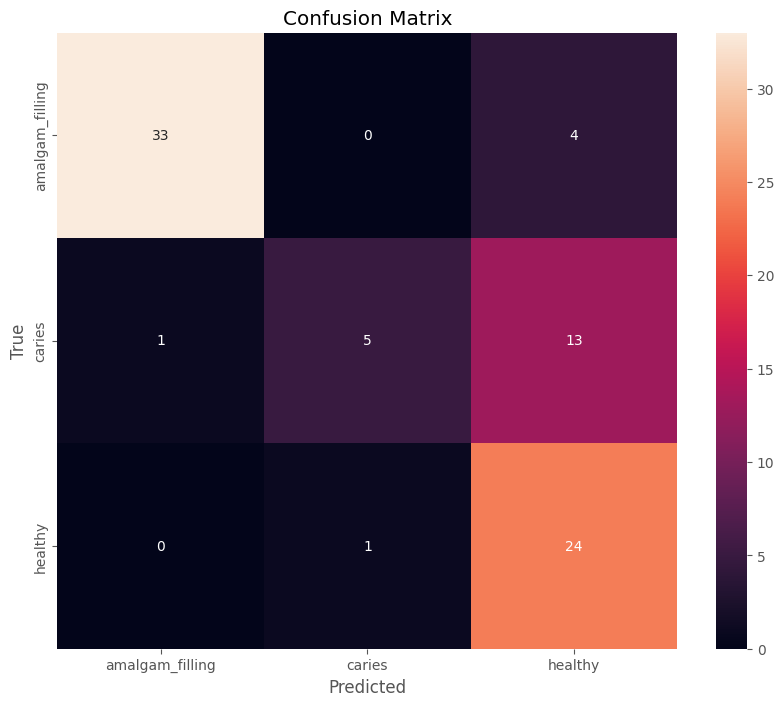

Final Test Accuracy for vit_b_16+vgg16: 0.7654


Testing pair 12/28

Training pair: vit_b_16 + resnet50


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


Epoch 2: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epoch 3: Val Accuracy: 0.4615, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Epoch 4: Val Accuracy: 0.6769, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch 5: Val Accuracy: 0.5077, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch 6: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Epoch 7: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch 8: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epoch 9: Val Accuracy: 0.6000, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Epoch 10: Val Accuracy: 0.7077, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Epoch 11: Val Accuracy: 0.7077, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch 12: Val Accuracy: 0.6308, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch 13: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch 14: Val Accuracy: 0.6154, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch 15: Val Accuracy: 0.7538, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch 16: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch 17: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch 18: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch 19: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch 20: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch 21: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch 22: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Epoch 23: Val Accuracy: 0.7538, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Epoch 24: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Epoch 25: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


Epoch 26: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Epoch 27: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Epoch 28: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch 29: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch 30: Val Accuracy: 0.7692, Best: 0.7692


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]



----- Detailed Metrics -----
Accuracy: 0.8395
Precision: 0.8944
Recall: 0.8395
F1 Score: 0.8143


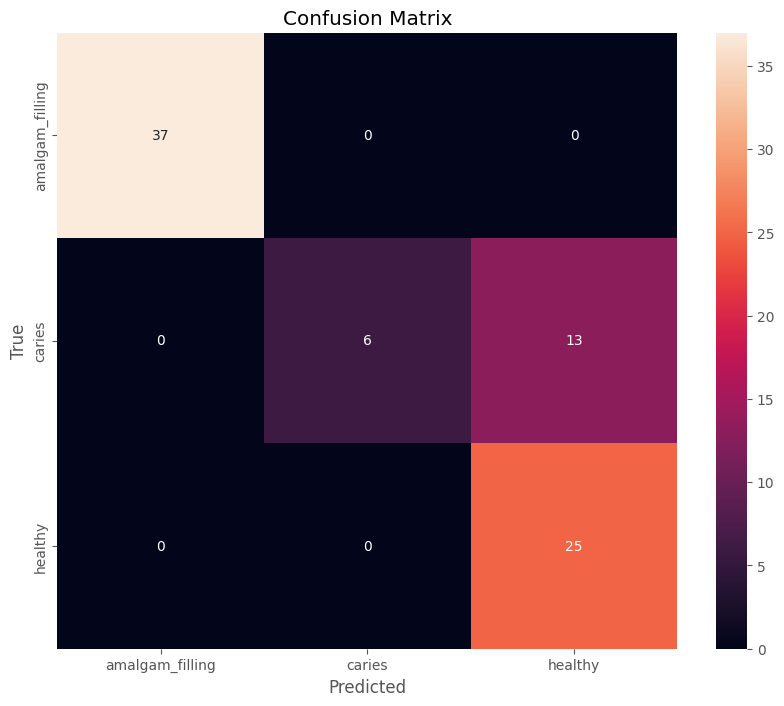

Final Test Accuracy for vit_b_16+resnet50: 0.8395


Testing pair 13/28

Training pair: vit_b_16 + resnet18


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 1: Val Accuracy: 0.6462, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch 2: Val Accuracy: 0.6154, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epoch 3: Val Accuracy: 0.5231, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch 4: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 5: Val Accuracy: 0.5692, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch 6: Val Accuracy: 0.5846, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epoch 7: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Epoch 8: Val Accuracy: 0.6462, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Epoch 9: Val Accuracy: 0.5538, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Epoch 10: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Epoch 11: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Epoch 12: Val Accuracy: 0.7385, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch 13: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Epoch 14: Val Accuracy: 0.7538, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Epoch 15: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


Epoch 16: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch 17: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epoch 18: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epoch 19: Val Accuracy: 0.7538, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch 20: Val Accuracy: 0.7846, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch 21: Val Accuracy: 0.7692, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epoch 22: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Epoch 23: Val Accuracy: 0.7846, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Epoch 24: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch 25: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch 26: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Epoch 27: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch 28: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch 29: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Epoch 30: Val Accuracy: 0.8154, Best: 0.8462


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]



----- Detailed Metrics -----
Accuracy: 0.9136
Precision: 0.9325
Recall: 0.9136
F1 Score: 0.9091


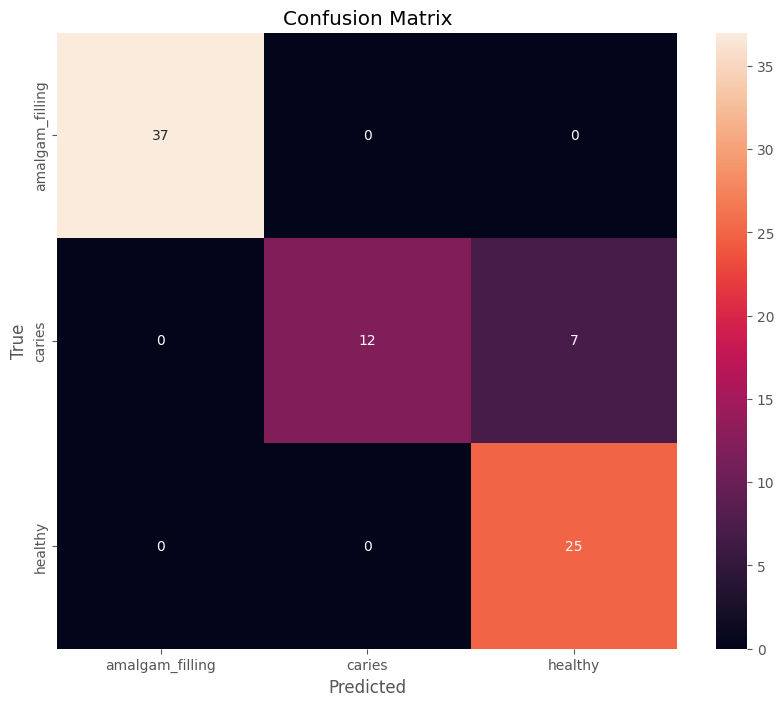

Final Test Accuracy for vit_b_16+resnet18: 0.9136


Testing pair 14/28

Training pair: mobilenet_v3_large + densenet121


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 1: Val Accuracy: 0.4308, Best: 0.4308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


Epoch 2: Val Accuracy: 0.5231, Best: 0.5231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


Epoch 3: Val Accuracy: 0.5231, Best: 0.5231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


Epoch 4: Val Accuracy: 0.5846, Best: 0.5846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


Epoch 5: Val Accuracy: 0.5692, Best: 0.5846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Epoch 6: Val Accuracy: 0.5231, Best: 0.5846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epoch 7: Val Accuracy: 0.4769, Best: 0.5846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Epoch 8: Val Accuracy: 0.6462, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


Epoch 9: Val Accuracy: 0.5692, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 10: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


Epoch 11: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Epoch 12: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


Epoch 13: Val Accuracy: 0.7077, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


Epoch 14: Val Accuracy: 0.7538, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


Epoch 15: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


Epoch 16: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Epoch 17: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Epoch 18: Val Accuracy: 0.7385, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


Epoch 19: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Epoch 20: Val Accuracy: 0.7385, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


Epoch 21: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Epoch 22: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Epoch 23: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Epoch 24: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


Epoch 25: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Epoch 26: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


Epoch 27: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Epoch 28: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


Epoch 29: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Epoch 30: Val Accuracy: 0.8000, Best: 0.8308


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]



----- Detailed Metrics -----
Accuracy: 0.9136
Precision: 0.9325
Recall: 0.9136
F1 Score: 0.9091


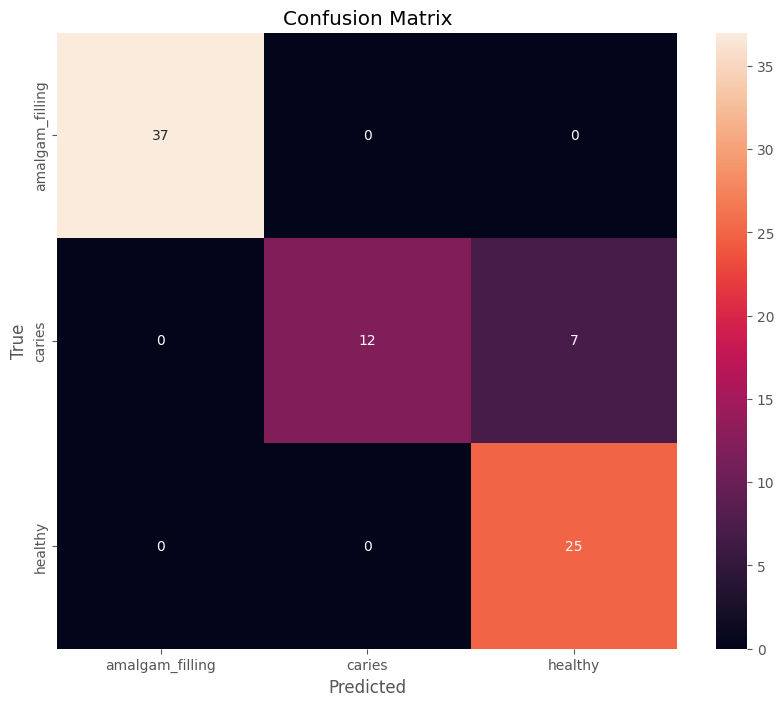

Final Test Accuracy for mobilenet_v3_large+densenet121: 0.9136


Testing pair 15/28

Training pair: mobilenet_v3_large + efficientnet_b4


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Epoch 1: Val Accuracy: 0.6615, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch 2: Val Accuracy: 0.4769, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch 3: Val Accuracy: 0.6000, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Epoch 4: Val Accuracy: 0.6308, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epoch 5: Val Accuracy: 0.6615, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Epoch 6: Val Accuracy: 0.6615, Best: 0.6615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch 7: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]


Epoch 8: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Epoch 9: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 10: Val Accuracy: 0.8615, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch 11: Val Accuracy: 0.8615, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Epoch 12: Val Accuracy: 0.8308, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 13: Val Accuracy: 0.8308, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Epoch 14: Val Accuracy: 0.8769, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epoch 15: Val Accuracy: 0.8769, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epoch 16: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Epoch 17: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch 18: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Epoch 19: Val Accuracy: 0.8462, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


Epoch 20: Val Accuracy: 0.8615, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


Epoch 21: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch 22: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Epoch 23: Val Accuracy: 0.8462, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


Epoch 24: Val Accuracy: 0.8615, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Epoch 25: Val Accuracy: 0.8462, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch 26: Val Accuracy: 0.8462, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 27: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch 28: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


Epoch 29: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Epoch 30: Val Accuracy: 0.8462, Best: 0.8769


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]



----- Detailed Metrics -----
Accuracy: 0.9012
Precision: 0.9016
Recall: 0.9012
F1 Score: 0.8980


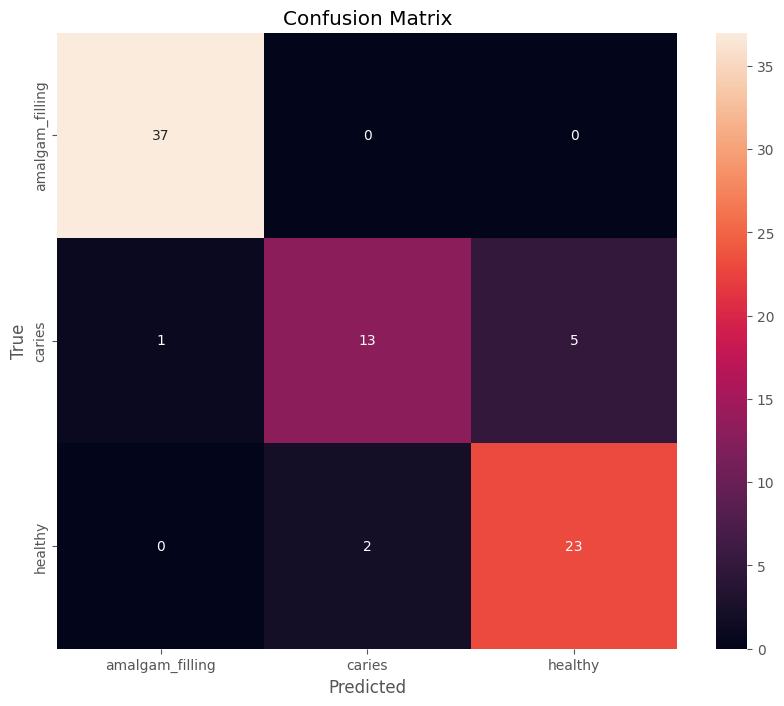

Final Test Accuracy for mobilenet_v3_large+efficientnet_b4: 0.9012


Testing pair 16/28

Training pair: mobilenet_v3_large + vgg16


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 1: Val Accuracy: 0.6308, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


Epoch 2: Val Accuracy: 0.5231, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch 3: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 4: Val Accuracy: 0.5077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Epoch 5: Val Accuracy: 0.4923, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 6: Val Accuracy: 0.4308, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Epoch 7: Val Accuracy: 0.6769, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Epoch 8: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Epoch 9: Val Accuracy: 0.7538, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Epoch 10: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


Epoch 11: Val Accuracy: 0.7077, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Epoch 12: Val Accuracy: 0.6923, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


Epoch 13: Val Accuracy: 0.5385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Epoch 14: Val Accuracy: 0.6308, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 15: Val Accuracy: 0.6462, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


Epoch 16: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 17: Val Accuracy: 0.6923, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Epoch 18: Val Accuracy: 0.6615, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


Epoch 19: Val Accuracy: 0.6615, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


Epoch 20: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


Epoch 21: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 22: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


Epoch 23: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Epoch 24: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Epoch 25: Val Accuracy: 0.7077, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


Epoch 26: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epoch 27: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]


Epoch 28: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 29: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Epoch 30: Val Accuracy: 0.7231, Best: 0.7692


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]



----- Detailed Metrics -----
Accuracy: 0.7778
Precision: 0.8050
Recall: 0.7778
F1 Score: 0.7737


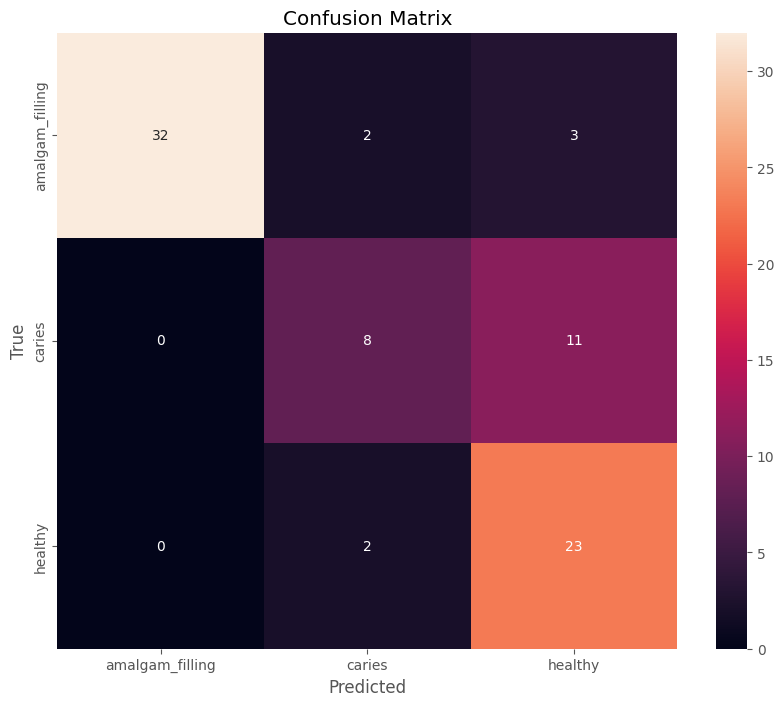

Final Test Accuracy for mobilenet_v3_large+vgg16: 0.7778


Testing pair 17/28

Training pair: mobilenet_v3_large + resnet50


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


Epoch 2: Val Accuracy: 0.5077, Best: 0.5077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Epoch 3: Val Accuracy: 0.3385, Best: 0.5077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epoch 4: Val Accuracy: 0.4462, Best: 0.5077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Epoch 5: Val Accuracy: 0.6154, Best: 0.6154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


Epoch 6: Val Accuracy: 0.6154, Best: 0.6154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 7: Val Accuracy: 0.5846, Best: 0.6154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


Epoch 8: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


Epoch 9: Val Accuracy: 0.6769, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


Epoch 10: Val Accuracy: 0.5846, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


Epoch 11: Val Accuracy: 0.4462, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 12: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


Epoch 13: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


Epoch 14: Val Accuracy: 0.7538, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Epoch 15: Val Accuracy: 0.6923, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


Epoch 16: Val Accuracy: 0.6923, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


Epoch 17: Val Accuracy: 0.7538, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


Epoch 18: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Epoch 19: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 20: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


Epoch 21: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


Epoch 22: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 23: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


Epoch 24: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


Epoch 25: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]


Epoch 26: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


Epoch 27: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Epoch 28: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Epoch 29: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Epoch 30: Val Accuracy: 0.7385, Best: 0.7692


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]



----- Detailed Metrics -----
Accuracy: 0.8642
Precision: 0.8663
Recall: 0.8642
F1 Score: 0.8647


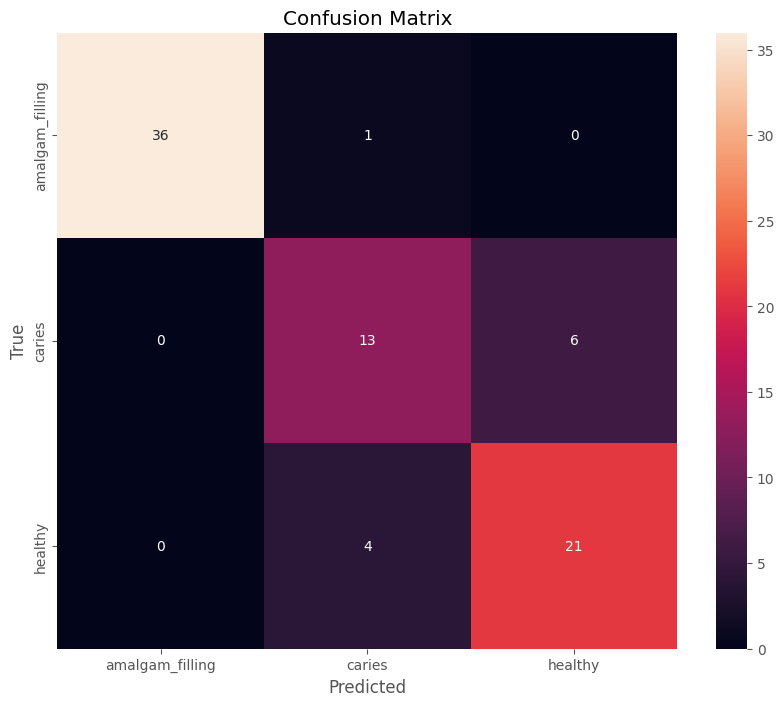

Final Test Accuracy for mobilenet_v3_large+resnet50: 0.8642


Testing pair 18/28

Training pair: mobilenet_v3_large + resnet18


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Epoch 1: Val Accuracy: 0.3538, Best: 0.3538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


Epoch 2: Val Accuracy: 0.3692, Best: 0.3692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


Epoch 3: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


Epoch 4: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


Epoch 5: Val Accuracy: 0.6923, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Epoch 6: Val Accuracy: 0.6615, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]


Epoch 7: Val Accuracy: 0.5846, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 8: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


Epoch 9: Val Accuracy: 0.7077, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Epoch 10: Val Accuracy: 0.6000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch 11: Val Accuracy: 0.6923, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Epoch 12: Val Accuracy: 0.6769, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


Epoch 13: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.71it/s]


Epoch 14: Val Accuracy: 0.6615, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.60it/s]


Epoch 15: Val Accuracy: 0.6615, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Epoch 16: Val Accuracy: 0.6615, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Epoch 17: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.59it/s]


Epoch 18: Val Accuracy: 0.7385, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch 19: Val Accuracy: 0.7846, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


Epoch 20: Val Accuracy: 0.7846, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch 21: Val Accuracy: 0.7846, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]


Epoch 22: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Epoch 23: Val Accuracy: 0.7692, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


Epoch 24: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Epoch 25: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch 26: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


Epoch 27: Val Accuracy: 0.8000, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]


Epoch 28: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]


Epoch 29: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Epoch 30: Val Accuracy: 0.8462, Best: 0.8462


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  4.22it/s]



----- Detailed Metrics -----
Accuracy: 0.8765
Precision: 0.8895
Recall: 0.8765
F1 Score: 0.8670


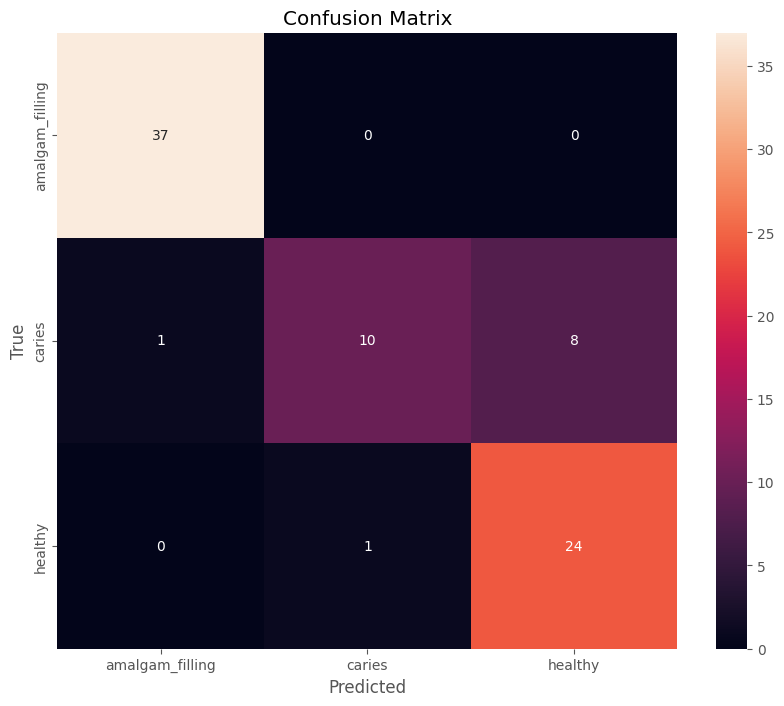

Final Test Accuracy for mobilenet_v3_large+resnet18: 0.8765


Testing pair 19/28

Training pair: densenet121 + efficientnet_b4


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 1: Val Accuracy: 0.3846, Best: 0.3846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 2: Val Accuracy: 0.3385, Best: 0.3846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epoch 3: Val Accuracy: 0.5846, Best: 0.5846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Epoch 4: Val Accuracy: 0.6308, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epoch 5: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 6: Val Accuracy: 0.8769, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epoch 7: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 8: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Epoch 9: Val Accuracy: 0.7538, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Epoch 10: Val Accuracy: 0.7231, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 11: Val Accuracy: 0.7385, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 12: Val Accuracy: 0.7538, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Epoch 13: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 14: Val Accuracy: 0.6923, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 15: Val Accuracy: 0.7692, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 16: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epoch 17: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 18: Val Accuracy: 0.8462, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Epoch 19: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 20: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 21: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Epoch 22: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 23: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 24: Val Accuracy: 0.8462, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 25: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epoch 26: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 27: Val Accuracy: 0.7692, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch 28: Val Accuracy: 0.7692, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


Epoch 29: Val Accuracy: 0.7846, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch 30: Val Accuracy: 0.7846, Best: 0.8769


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]



----- Detailed Metrics -----
Accuracy: 0.9506
Precision: 0.9574
Recall: 0.9506
F1 Score: 0.9508


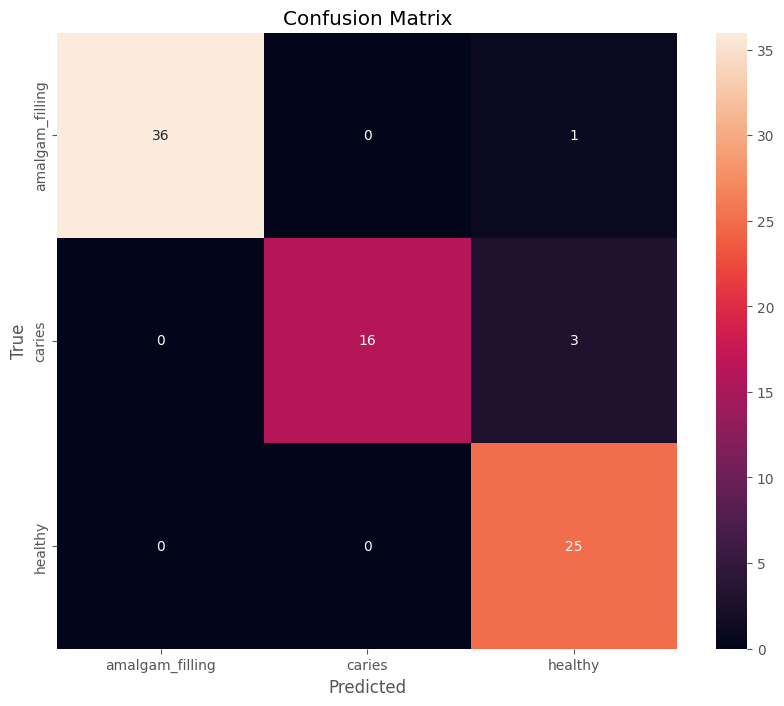

Final Test Accuracy for densenet121+efficientnet_b4: 0.9506


Testing pair 20/28

Training pair: densenet121 + vgg16


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epoch 2: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 3: Val Accuracy: 0.3385, Best: 0.3385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epoch 4: Val Accuracy: 0.4923, Best: 0.4923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch 5: Val Accuracy: 0.6308, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epoch 6: Val Accuracy: 0.7231, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 7: Val Accuracy: 0.6923, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 8: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epoch 9: Val Accuracy: 0.6000, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epoch 10: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 11: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch 12: Val Accuracy: 0.7231, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epoch 13: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 14: Val Accuracy: 0.6615, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epoch 15: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 16: Val Accuracy: 0.6769, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 17: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 18: Val Accuracy: 0.7846, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 19: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch 20: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch 21: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch 22: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch 23: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Epoch 24: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 25: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 26: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epoch 27: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Epoch 28: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epoch 29: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch 30: Val Accuracy: 0.8154, Best: 0.8308


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9267
Recall: 0.9259
F1 Score: 0.9253


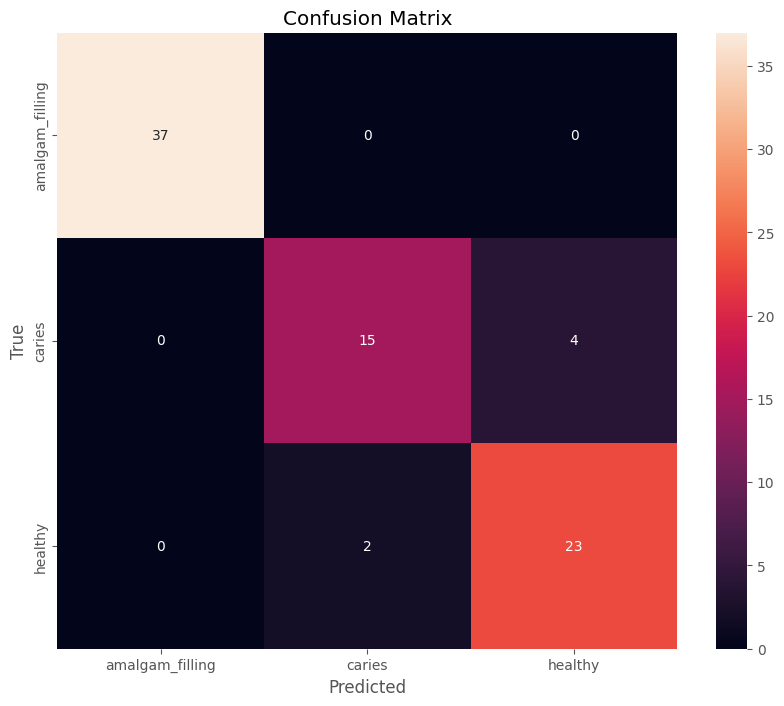

Final Test Accuracy for densenet121+vgg16: 0.9259


Testing pair 21/28

Training pair: densenet121 + resnet50


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epoch 2: Val Accuracy: 0.3385, Best: 0.3385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epoch 3: Val Accuracy: 0.3692, Best: 0.3692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 4: Val Accuracy: 0.7231, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch 5: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


Epoch 6: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


Epoch 7: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


Epoch 8: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Epoch 9: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Epoch 10: Val Accuracy: 0.6769, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


Epoch 11: Val Accuracy: 0.7692, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 12: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 13: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


Epoch 14: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Epoch 15: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


Epoch 16: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Epoch 17: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch 18: Val Accuracy: 0.7692, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 19: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epoch 20: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


Epoch 21: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epoch 22: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


Epoch 23: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]


Epoch 24: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


Epoch 25: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 26: Val Accuracy: 0.7846, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


Epoch 27: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 28: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


Epoch 29: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 30: Val Accuracy: 0.8000, Best: 0.8462


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]



----- Detailed Metrics -----
Accuracy: 0.9383
Precision: 0.9454
Recall: 0.9383
F1 Score: 0.9355


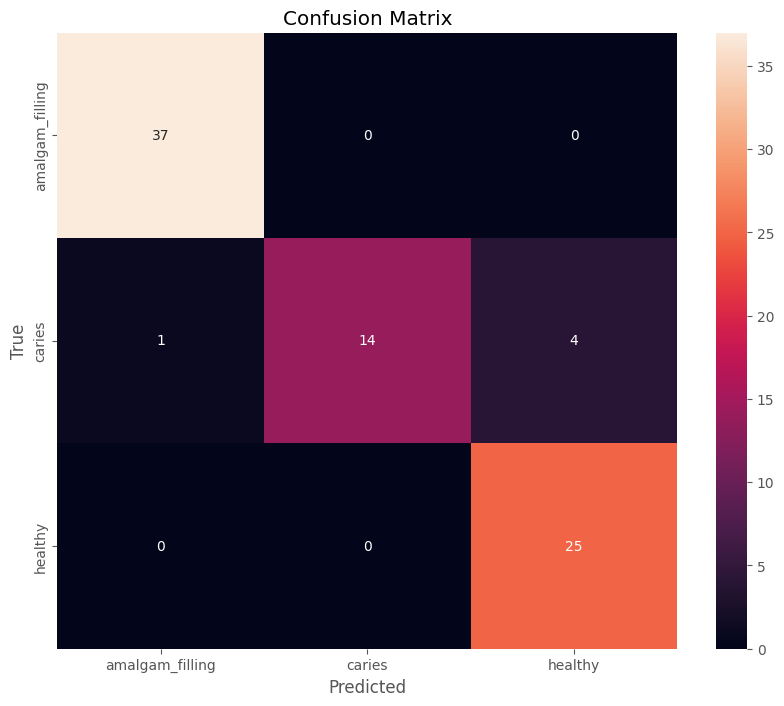

Final Test Accuracy for densenet121+resnet50: 0.9383


Testing pair 22/28

Training pair: densenet121 + resnet18


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch 1: Val Accuracy: 0.6000, Best: 0.6000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


Epoch 2: Val Accuracy: 0.3385, Best: 0.6000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch 3: Val Accuracy: 0.6154, Best: 0.6154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch 4: Val Accuracy: 0.6462, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Epoch 5: Val Accuracy: 0.5077, Best: 0.6462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


Epoch 6: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]


Epoch 7: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Epoch 8: Val Accuracy: 0.7231, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 9: Val Accuracy: 0.6308, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 10: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch 11: Val Accuracy: 0.6769, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch 12: Val Accuracy: 0.8769, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Epoch 13: Val Accuracy: 0.7692, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


Epoch 14: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch 15: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch 16: Val Accuracy: 0.7538, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]


Epoch 17: Val Accuracy: 0.8462, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


Epoch 18: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


Epoch 19: Val Accuracy: 0.7385, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch 20: Val Accuracy: 0.8000, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Epoch 21: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


Epoch 22: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]


Epoch 23: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epoch 24: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


Epoch 25: Val Accuracy: 0.8308, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]


Epoch 26: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 27: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Epoch 28: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]


Epoch 29: Val Accuracy: 0.8154, Best: 0.8769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epoch 30: Val Accuracy: 0.8154, Best: 0.8769


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9311
Recall: 0.9259
F1 Score: 0.9243


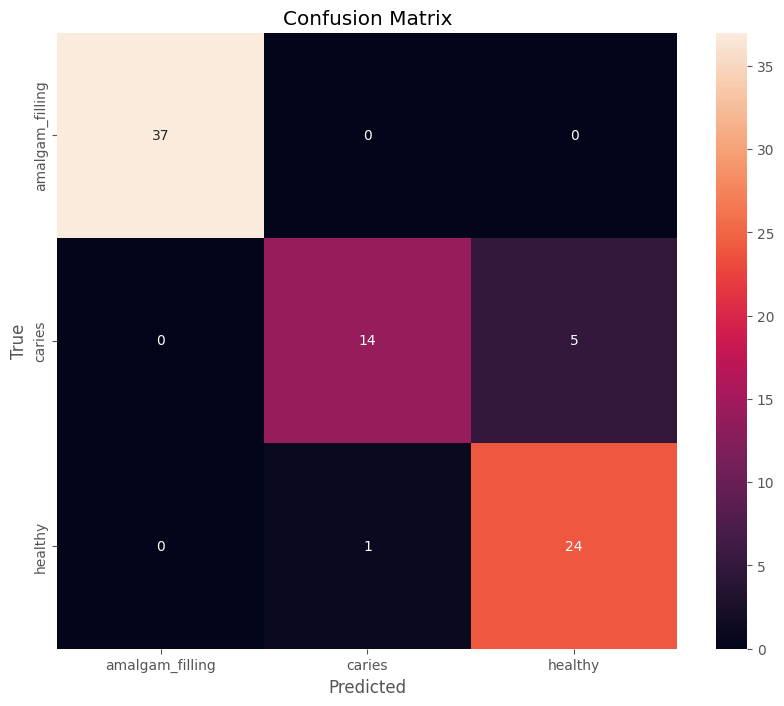

Final Test Accuracy for densenet121+resnet18: 0.9259


Testing pair 23/28

Training pair: efficientnet_b4 + vgg16


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch 1: Val Accuracy: 0.6154, Best: 0.6154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 2: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 3: Val Accuracy: 0.6615, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch 4: Val Accuracy: 0.7231, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epoch 5: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 6: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 7: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch 8: Val Accuracy: 0.8615, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Epoch 9: Val Accuracy: 0.8462, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 10: Val Accuracy: 0.8154, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 11: Val Accuracy: 0.6615, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 12: Val Accuracy: 0.7385, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 13: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch 14: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epoch 15: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 16: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


Epoch 17: Val Accuracy: 0.7538, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch 18: Val Accuracy: 0.7692, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 19: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epoch 20: Val Accuracy: 0.7692, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 21: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 22: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epoch 23: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 24: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 25: Val Accuracy: 0.7846, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch 26: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 27: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epoch 28: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch 29: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 30: Val Accuracy: 0.8000, Best: 0.8615


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]



----- Detailed Metrics -----
Accuracy: 0.9012
Precision: 0.9031
Recall: 0.9012
F1 Score: 0.9020


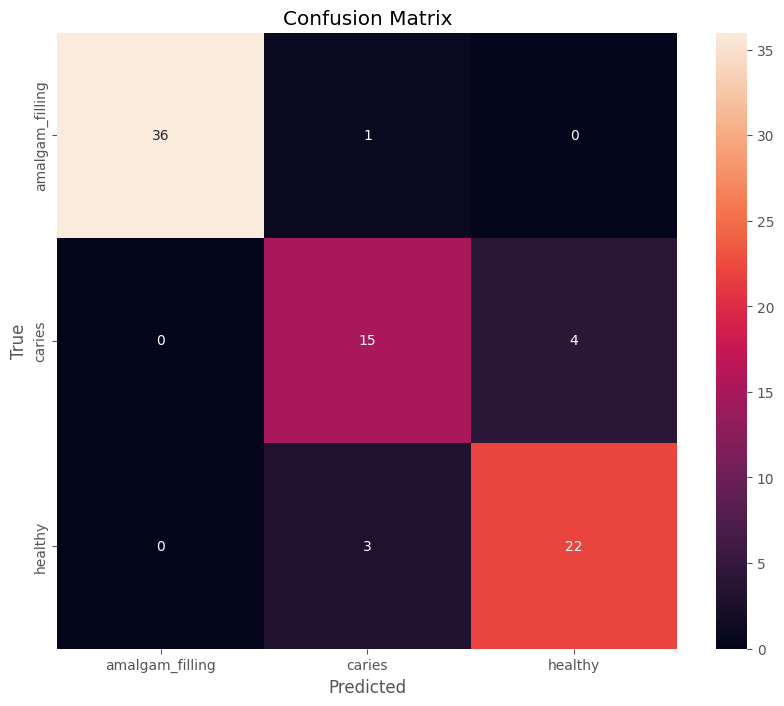

Final Test Accuracy for efficientnet_b4+vgg16: 0.9012


Testing pair 24/28

Training pair: efficientnet_b4 + resnet50


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


Epoch 1: Val Accuracy: 0.4615, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch 2: Val Accuracy: 0.3231, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 3: Val Accuracy: 0.6769, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Epoch 4: Val Accuracy: 0.5692, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 5: Val Accuracy: 0.7538, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Epoch 6: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 7: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 8: Val Accuracy: 0.7538, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Epoch 9: Val Accuracy: 0.7538, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch 10: Val Accuracy: 0.7846, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Epoch 11: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch 12: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 13: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 14: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Epoch 15: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Epoch 16: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch 17: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Epoch 18: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epoch 19: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epoch 20: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Epoch 21: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epoch 22: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 23: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch 24: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Epoch 25: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Epoch 26: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epoch 27: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Epoch 28: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 29: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


Epoch 30: Val Accuracy: 0.7846, Best: 0.8462


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9311
Recall: 0.9259
F1 Score: 0.9243


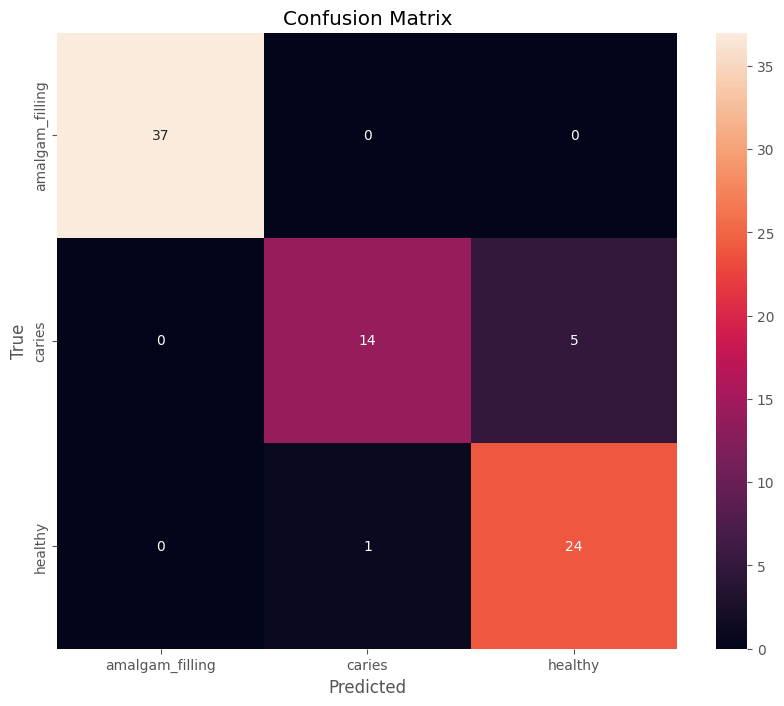

Final Test Accuracy for efficientnet_b4+resnet50: 0.9259


Testing pair 25/28

Training pair: efficientnet_b4 + resnet18


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Epoch 1: Val Accuracy: 0.3538, Best: 0.3538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


Epoch 2: Val Accuracy: 0.6769, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Epoch 3: Val Accuracy: 0.6615, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


Epoch 4: Val Accuracy: 0.5538, Best: 0.6769


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch 5: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Epoch 6: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epoch 7: Val Accuracy: 0.7385, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Epoch 8: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epoch 9: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


Epoch 10: Val Accuracy: 0.8000, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Epoch 11: Val Accuracy: 0.7385, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]


Epoch 12: Val Accuracy: 0.6923, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


Epoch 13: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


Epoch 14: Val Accuracy: 0.7692, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


Epoch 15: Val Accuracy: 0.7538, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epoch 16: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch 17: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epoch 18: Val Accuracy: 0.7846, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Epoch 19: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


Epoch 20: Val Accuracy: 0.8615, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


Epoch 21: Val Accuracy: 0.8308, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 22: Val Accuracy: 0.8308, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epoch 23: Val Accuracy: 0.8308, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


Epoch 24: Val Accuracy: 0.8154, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


Epoch 25: Val Accuracy: 0.8154, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


Epoch 26: Val Accuracy: 0.8154, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


Epoch 27: Val Accuracy: 0.8154, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epoch 28: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch 29: Val Accuracy: 0.8000, Best: 0.8615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Epoch 30: Val Accuracy: 0.8154, Best: 0.8615


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9267
Recall: 0.9259
F1 Score: 0.9253


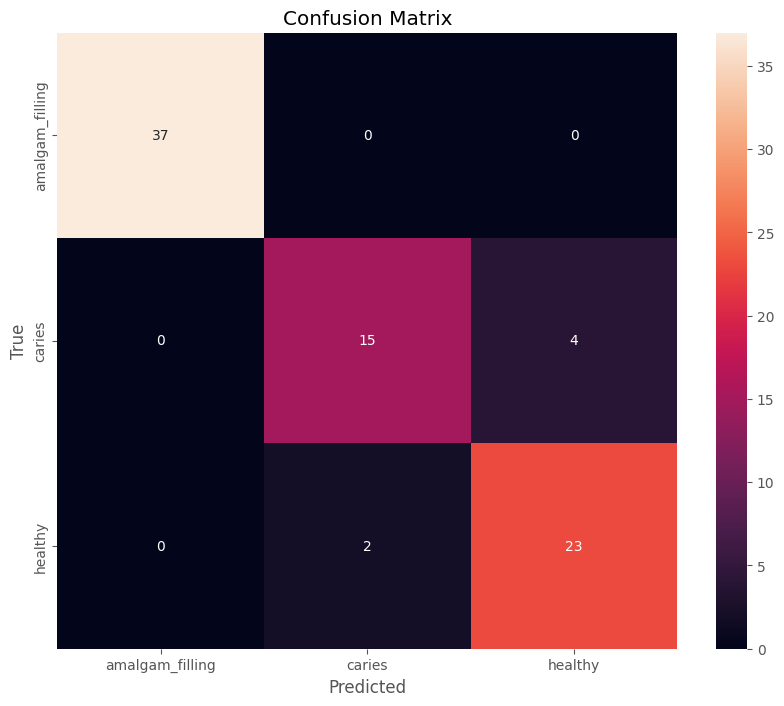

Final Test Accuracy for efficientnet_b4+resnet18: 0.9259


Testing pair 26/28

Training pair: vgg16 + resnet50


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch 2: Val Accuracy: 0.3538, Best: 0.3538


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch 3: Val Accuracy: 0.3846, Best: 0.3846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch 4: Val Accuracy: 0.4615, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epoch 5: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epoch 6: Val Accuracy: 0.6769, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epoch 7: Val Accuracy: 0.5077, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch 8: Val Accuracy: 0.4462, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epoch 9: Val Accuracy: 0.6308, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Epoch 10: Val Accuracy: 0.6923, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 11: Val Accuracy: 0.6769, Best: 0.6923


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch 12: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch 13: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch 14: Val Accuracy: 0.7077, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


Epoch 15: Val Accuracy: 0.7538, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epoch 16: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epoch 17: Val Accuracy: 0.7385, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epoch 18: Val Accuracy: 0.7231, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epoch 19: Val Accuracy: 0.7231, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epoch 20: Val Accuracy: 0.7231, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epoch 21: Val Accuracy: 0.7538, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Epoch 22: Val Accuracy: 0.7538, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Epoch 23: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 24: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epoch 25: Val Accuracy: 0.7538, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epoch 26: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch 27: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epoch 28: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epoch 29: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epoch 30: Val Accuracy: 0.8000, Best: 0.8000


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]



----- Detailed Metrics -----
Accuracy: 0.8395
Precision: 0.8944
Recall: 0.8395
F1 Score: 0.8143


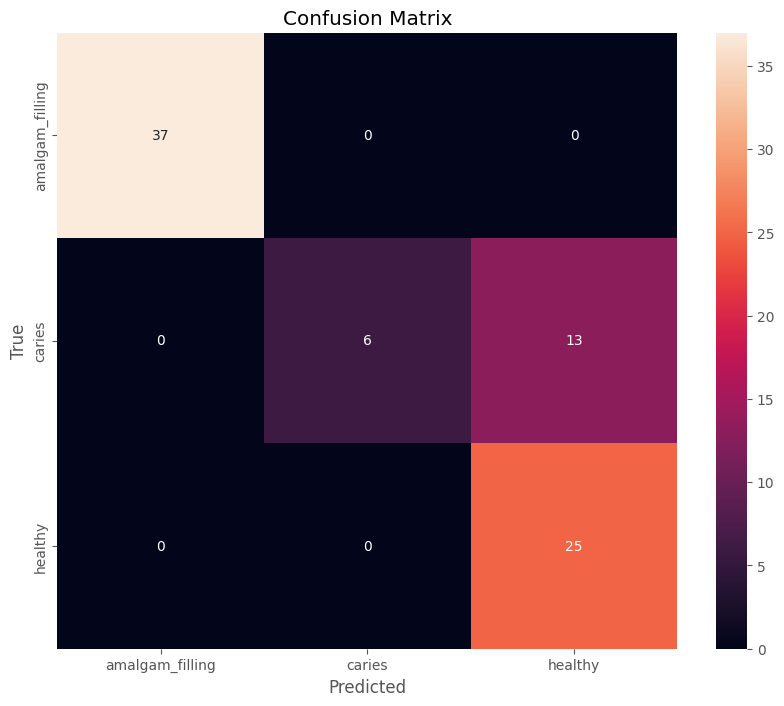

Final Test Accuracy for vgg16+resnet50: 0.8395


Testing pair 27/28

Training pair: vgg16 + resnet18


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch 1: Val Accuracy: 0.3692, Best: 0.3692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]


Epoch 2: Val Accuracy: 0.3538, Best: 0.3692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Epoch 3: Val Accuracy: 0.5846, Best: 0.5846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epoch 4: Val Accuracy: 0.7231, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]


Epoch 5: Val Accuracy: 0.7231, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch 6: Val Accuracy: 0.6923, Best: 0.7231


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]


Epoch 7: Val Accuracy: 0.7385, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]


Epoch 8: Val Accuracy: 0.7077, Best: 0.7385


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 9: Val Accuracy: 0.7846, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epoch 10: Val Accuracy: 0.6923, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epoch 11: Val Accuracy: 0.7077, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Epoch 12: Val Accuracy: 0.7077, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epoch 13: Val Accuracy: 0.6462, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 14: Val Accuracy: 0.7692, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epoch 15: Val Accuracy: 0.7538, Best: 0.7846


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epoch 16: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch 17: Val Accuracy: 0.7538, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch 18: Val Accuracy: 0.7692, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 19: Val Accuracy: 0.6615, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch 20: Val Accuracy: 0.7231, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Epoch 21: Val Accuracy: 0.7077, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epoch 22: Val Accuracy: 0.7231, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epoch 23: Val Accuracy: 0.7385, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


Epoch 24: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epoch 25: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 26: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Epoch 27: Val Accuracy: 0.8154, Best: 0.8154


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epoch 28: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 29: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Epoch 30: Val Accuracy: 0.8308, Best: 0.8308


Evaluating test: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]



----- Detailed Metrics -----
Accuracy: 0.9259
Precision: 0.9311
Recall: 0.9259
F1 Score: 0.9243


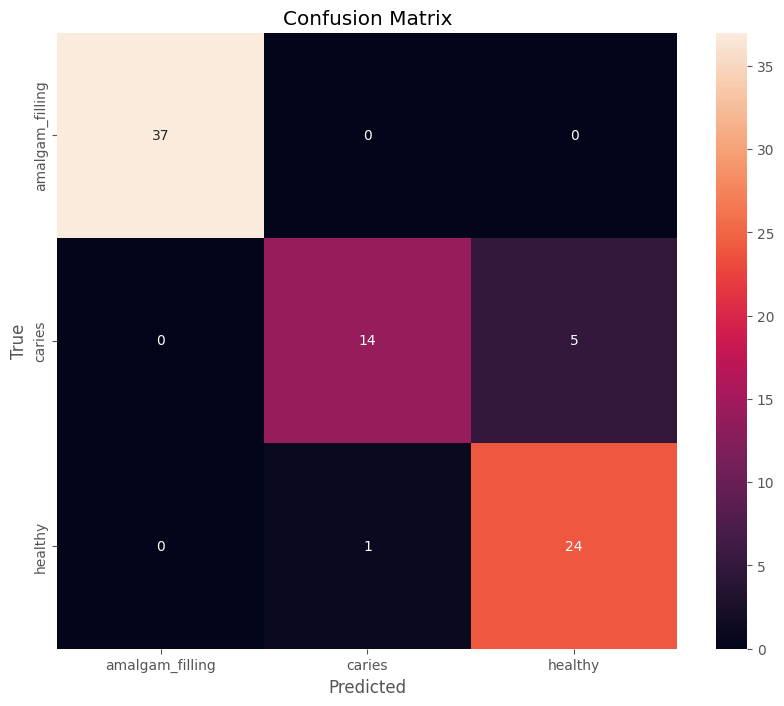

Final Test Accuracy for vgg16+resnet18: 0.9259


Testing pair 28/28

Training pair: resnet50 + resnet18


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Epoch 1: Val Accuracy: 0.3231, Best: 0.3231


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Epoch 2: Val Accuracy: 0.4615, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]


Epoch 3: Val Accuracy: 0.3692, Best: 0.4615


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Epoch 4: Val Accuracy: 0.6308, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


Epoch 5: Val Accuracy: 0.6000, Best: 0.6308


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Epoch 6: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


Epoch 7: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Epoch 8: Val Accuracy: 0.7077, Best: 0.7077


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


Epoch 9: Val Accuracy: 0.7538, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]


Epoch 10: Val Accuracy: 0.6462, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epoch 11: Val Accuracy: 0.6000, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


Epoch 12: Val Accuracy: 0.7231, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


Epoch 13: Val Accuracy: 0.6769, Best: 0.7538


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


Epoch 14: Val Accuracy: 0.7692, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


Epoch 15: Val Accuracy: 0.7538, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Epoch 16: Val Accuracy: 0.7385, Best: 0.7692


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Epoch 17: Val Accuracy: 0.8000, Best: 0.8000


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


Epoch 18: Val Accuracy: 0.8308, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


Epoch 19: Val Accuracy: 0.8154, Best: 0.8308


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch 20: Val Accuracy: 0.8462, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epoch 21: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


Epoch 22: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


Epoch 23: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epoch 24: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


Epoch 25: Val Accuracy: 0.8154, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch 26: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


Epoch 27: Val Accuracy: 0.8000, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epoch 28: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch 29: Val Accuracy: 0.8308, Best: 0.8462


Evaluating val: 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


Epoch 30: Val Accuracy: 0.8308, Best: 0.8462


Evaluating test: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]



----- Detailed Metrics -----
Accuracy: 0.9012
Precision: 0.9123
Recall: 0.9012
F1 Score: 0.8973


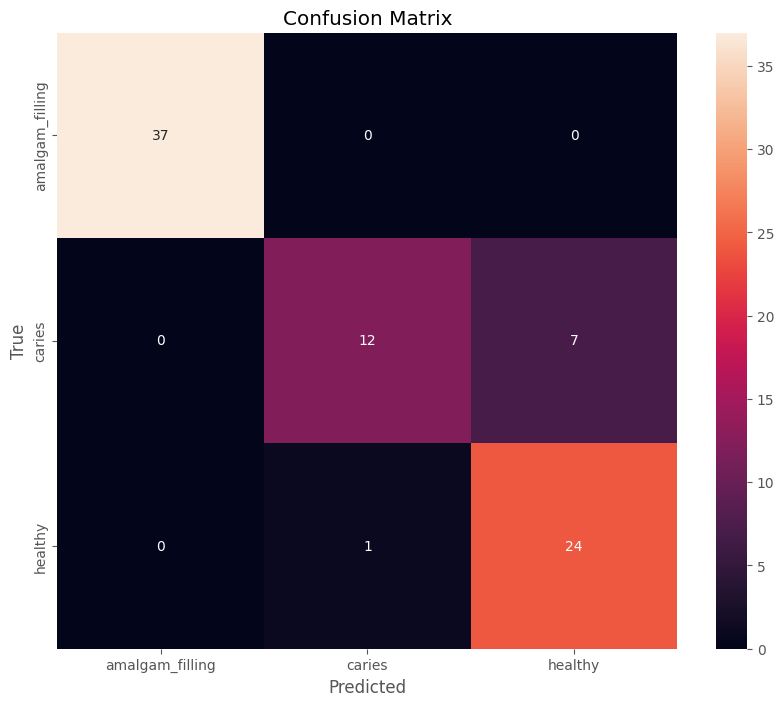

Final Test Accuracy for resnet50+resnet18: 0.9012

FINAL RESULTS SUMMARY
Rank Model 1              Model 2              Accuracy   F1-Score  
--------------------------------------------------------------------------------
19   densenet121          efficientnet_b4      0.9506     0.9508    
4    vit_b_32             efficientnet_b4      0.9383     0.9374    
21   densenet121          resnet50             0.9383     0.9355    
3    vit_b_32             densenet121          0.9259     0.9259    
20   densenet121          vgg16                0.9259     0.9253    
27   vgg16                resnet18             0.9259     0.9243    
24   efficientnet_b4      resnet50             0.9259     0.9243    
25   efficientnet_b4      resnet18             0.9259     0.9253    
9    vit_b_16             densenet121          0.9259     0.9229    
22   densenet121          resnet18             0.9259     0.9243    
10   vit_b_16             efficientnet_b4      0.9259     0.9229    
13   vit_b_16     

In [ ]:
def main():
    # Set the data directory
    data_dir = '/content/drive/MyDrive/Dentisrty/panoramic_data'

    # Load data
    print("Loading data...")
    images, labels = load_data(data_dir)
    print(f"Loaded {len(images)} images")

    # Plot class distribution
    plot_distribution(labels)

    # Split data
    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=CONFIG['SEED']
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=CONFIG['SEED']
    )

    print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

    # Create datasets and dataloaders
    print("Creating datasets and dataloaders...")
    train_dataset = DentalDataset(X_train, y_train, transform=train_transforms)
    val_dataset = DentalDataset(X_val, y_val, transform=val_transforms)
    test_dataset = DentalDataset(X_test, y_test, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True)

    # Generate all possible pairs of models
    model_pairs = list(combinations(MODELS_TO_TEST, 2))
    print(f"\nTotal model pairs to test: {len(model_pairs)}")
    for i, (model1, model2) in enumerate(model_pairs):
        print(f"{i+1:2d}. {model1} + {model2}")

    # Store results for all pairs
    all_results = []

    # Test each pair
    for i, (model1_name, model2_name) in enumerate(model_pairs):
        print(f"\n\nTesting pair {i+1}/{len(model_pairs)}")

        try:
            result = train_and_evaluate_model_pair(
                model1_name, model2_name,
                train_loader, val_loader, test_loader
            )
            all_results.append(result)

            # Save intermediate results
            temp_df = pd.DataFrame(all_results)
            temp_df.to_csv(os.path.join(CONFIG['METRICS_PATH'], 'ds_all_pairs_results_temp.csv'), index=False)

        except Exception as e:
            print(f"Error with pair {model1_name}+{model2_name}: {e}")
            all_results.append({
                'model1_name': model1_name,
                'model2_name': model2_name,
                'test_accuracy': 0.0,
                'test_precision': 0.0,
                'test_recall': 0.0,
                'test_f1_score': 0.0
            })

    # Save final results
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('test_accuracy', ascending=False)
    results_df.to_csv(os.path.join(CONFIG['METRICS_PATH'], 'ds_all_pairs_results_final.csv'), index=False)

    # Print summary
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    print(f"{'Rank':<4} {'Model 1':<20} {'Model 2':<20} {'Accuracy':<10} {'F1-Score':<10}")
    print("-"*80)
    for i, row in results_df.iterrows():
        print(f"{i+1:<4} {row['model1_name']:<20} {row['model2_name']:<20} {row['test_accuracy']:<10.4f} {row['test_f1_score']:<10.4f}")

    # Find best performing pair
    best_pair = results_df.iloc[0]
    print(f"\nBest performing pair: {best_pair['model1_name']} + {best_pair['model2_name']}")
    print(f"Best accuracy: {best_pair['test_accuracy']:.4f}")
    print(f"Best F1-score: {best_pair['test_f1_score']:.4f}")

    print(f"\nResults saved to: {os.path.join(CONFIG['METRICS_PATH'], 'ds_all_pairs_results_final.csv')}")

if __name__ == '__main__':
    main()